### Imports and Initial Setup

In [22]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ndcg_score, average_precision_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter

# Transformers and PyTorch
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import Dataset, load_from_disk
import evaluate

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Set plot styles
plt.style.use('fivethirtyeight')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 12

[nltk_data] Downloading package stopwords to /home/hmehdi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hmehdi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/hmehdi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Load and Prepare the Datasets

In [23]:
def load_amazon_data():
    print("Loading Books dataset...")
    try:
        books_df = pd.read_csv('data/amazon_reviews_us_Books_v1_02.tsv', 
                              sep='\t',
                              on_bad_lines='skip',    # For newer pandas versions
                              quoting=3,              # QUOTE_NONE
                              encoding='utf-8',
                              engine='python')        # Use python engine for more flexibility
        print(f"Successfully loaded Books dataset with {len(books_df)} rows")
    except Exception as e:
        print(f"Error loading Books dataset: {e}")
        books_df = pd.DataFrame()  # Create empty dataframe if loading fails

    print("Loading Electronics dataset...")
    try:
        electronics_df = pd.read_csv('data/amazon_reviews_us_Electronics_v1_00.tsv',
                                   sep='\t',
                                   on_bad_lines='skip',
                                   quoting=3, 
                                   encoding='utf-8',
                                   engine='python')
        print(f"Successfully loaded Electronics dataset with {len(electronics_df)} rows")
    except Exception as e:
        print(f"Error loading Electronics dataset: {e}")
        electronics_df = pd.DataFrame()  # Create empty dataframe if loading fails

    # Add category column for easy identification if dataframes are not empty
    if not books_df.empty:
        books_df['category'] = 'Books'
    if not electronics_df.empty:
        electronics_df['category'] = 'Electronics'

    print("\n===== DATASET OVERVIEW =====")
    print(f"Books dataset: {len(books_df):,} reviews")
    print(f"Electronics dataset: {len(electronics_df):,} reviews")

    # Continue only if we have data
    if books_df.empty or electronics_df.empty:
        print("ERROR: One or both datasets failed to load. Please check the file paths and try again.")
        return None, None
    
    # Sample from both datasets to keep analysis manageable
    sample_size = 50000  # Adjust based on your computational resources
    if len(books_df) > sample_size:
        books_sample = books_df.sample(sample_size, random_state=42)
    else:
        books_sample = books_df

    if len(electronics_df) > sample_size:
        electronics_sample = electronics_df.sample(sample_size, random_state=42)
    else:
        electronics_sample = electronics_df

    # Convert star_rating to numeric
    books_sample['star_rating'] = pd.to_numeric(books_sample['star_rating'], errors='coerce')
    electronics_sample['star_rating'] = pd.to_numeric(electronics_sample['star_rating'], errors='coerce')

    # Convert vote columns to numeric
    books_sample['helpful_votes'] = pd.to_numeric(books_sample['helpful_votes'], errors='coerce')
    books_sample['total_votes'] = pd.to_numeric(books_sample['total_votes'], errors='coerce')
    electronics_sample['helpful_votes'] = pd.to_numeric(electronics_sample['helpful_votes'], errors='coerce')
    electronics_sample['total_votes'] = pd.to_numeric(electronics_sample['total_votes'], errors='coerce')

    # Fill NaN values
    books_sample['star_rating'] = books_sample['star_rating'].fillna(0)
    books_sample['helpful_votes'] = books_sample['helpful_votes'].fillna(0)
    books_sample['total_votes'] = books_sample['total_votes'].fillna(0)
    electronics_sample['star_rating'] = electronics_sample['star_rating'].fillna(0)
    electronics_sample['helpful_votes'] = electronics_sample['helpful_votes'].fillna(0)
    electronics_sample['total_votes'] = electronics_sample['total_votes'].fillna(0)

    # Check for missing values
    print("\nMissing values in Books sample:")
    print(books_sample.isnull().sum())
    print("\nMissing values in Electronics sample:")
    print(electronics_sample.isnull().sum())
    
    return books_sample, electronics_sample

# Load the data
books_sample, electronics_sample = load_amazon_data()

Loading Books dataset...
Successfully loaded Books dataset with 3105520 rows
Loading Electronics dataset...
Successfully loaded Electronics dataset with 3093869 rows

===== DATASET OVERVIEW =====
Books dataset: 3,105,520 reviews
Electronics dataset: 3,093,869 reviews

Missing values in Books sample:
marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      1
review_body          0
review_date          0
category             0
dtype: int64

Missing values in Electronics sample:
marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
rev

### Add Sentiment Labels and Helpfulness Ratio

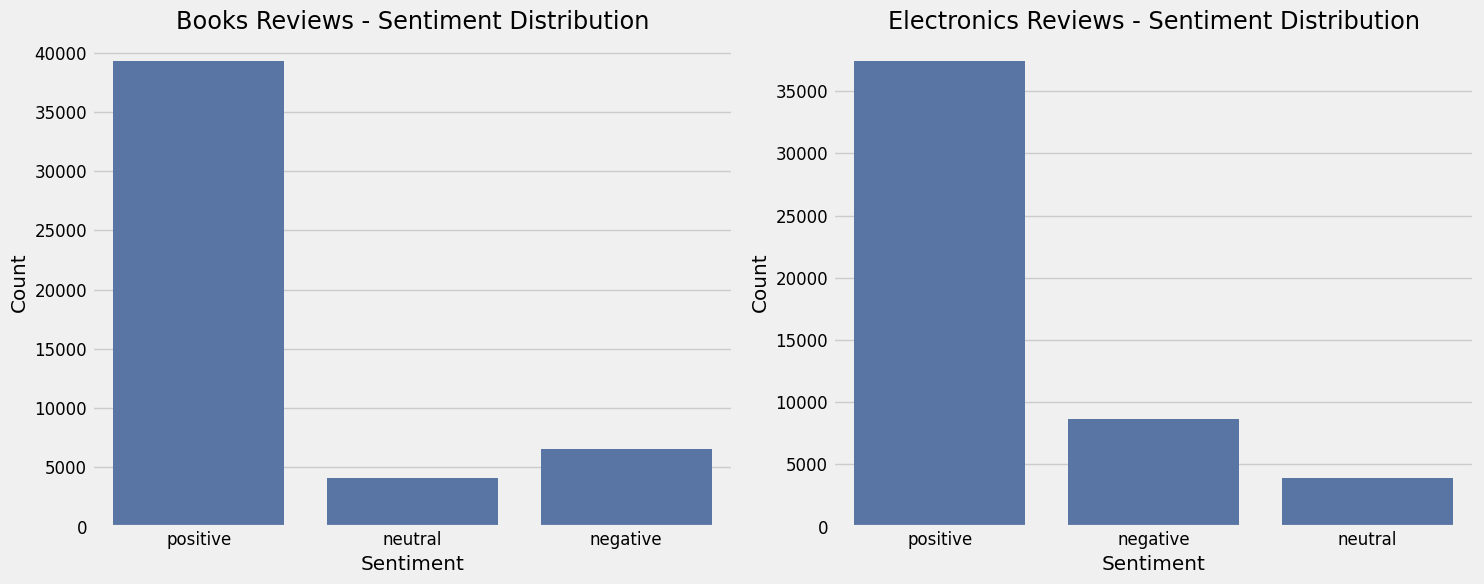

In [24]:
def add_sentiment_labels(df):
    # Convert star_rating to categorical sentiment
    df['sentiment'] = df['star_rating'].apply(
        lambda x: 'negative' if x <= 2 else ('neutral' if x == 3 else 'positive')
    )
    return df

# Process the samples
books_processed = add_sentiment_labels(books_sample)
electronics_processed = add_sentiment_labels(electronics_sample)

# Create helpfulness ratio for analysis
def add_helpfulness_ratio(df):
    # Avoid division by zero
    df['helpfulness_ratio'] = df.apply(
        lambda row: row['helpful_votes'] / row['total_votes'] if row['total_votes'] > 0 else 0, 
        axis=1
    )
    return df

books_processed = add_helpfulness_ratio(books_processed)
electronics_processed = add_helpfulness_ratio(electronics_processed)

# Helper function for aspect-based sentiment analysis
def extract_aspects(text):
    if pd.isna(text):
        return []
    
    # Simple rule-based aspect extraction
    # Look for noun phrases after sentiment words or before adjectives
    aspects = []
    
    # Common product aspects
    book_aspects = ["plot", "character", "writing", "author", "story", "ending", "price"]
    electronics_aspects = ["battery", "screen", "quality", "price", "durability", "speed", "performance"]
    
    # Check for these aspects in the text
    for aspect in book_aspects + electronics_aspects:
        if aspect in text.lower():
            aspects.append(aspect)
    
    return aspects

# Add aspect extraction
books_processed['aspects'] = books_processed['review_body'].apply(extract_aspects)
electronics_processed['aspects'] = electronics_processed['review_body'].apply(extract_aspects)

# Visualize the class distribution
plt.figure(figsize=(15, 6))

# Books distribution
plt.subplot(1, 2, 1)
sns.countplot(x='sentiment', data=books_processed)
plt.title('Books Reviews - Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Electronics distribution
plt.subplot(1, 2, 2)
sns.countplot(x='sentiment', data=electronics_processed)
plt.title('Electronics Reviews - Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Additional Exploratory Analysis - Class Imbalance and Helpfulness

<Figure size 1200x600 with 0 Axes>

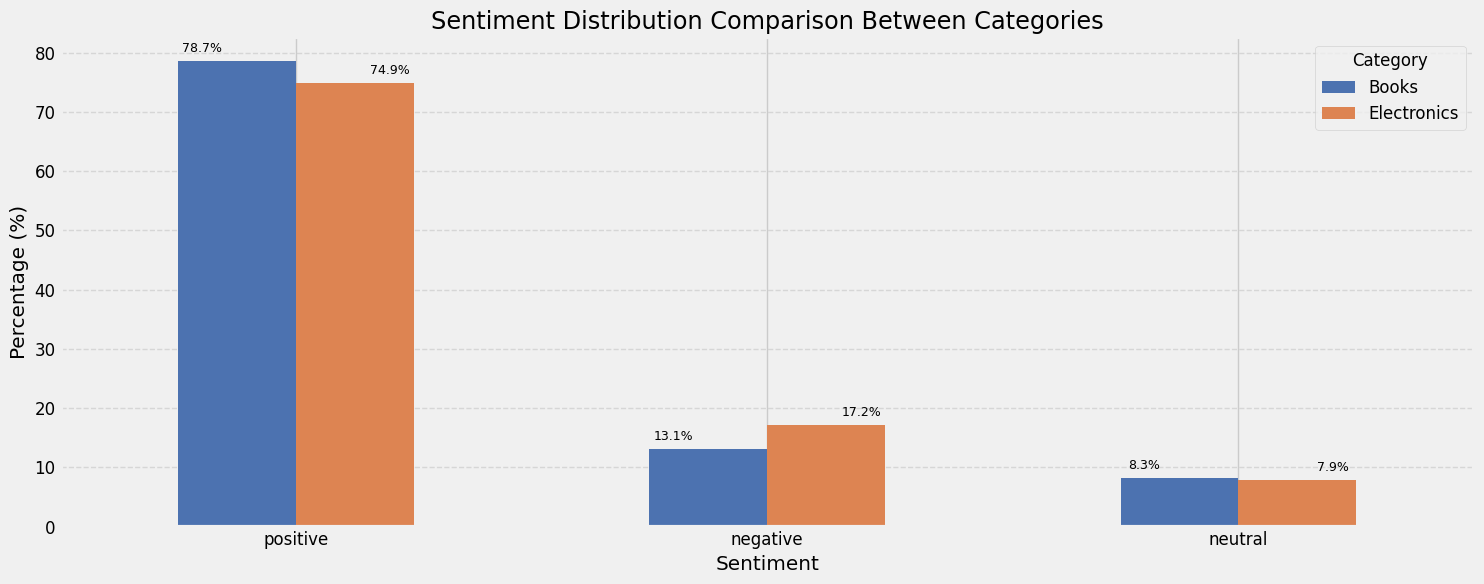

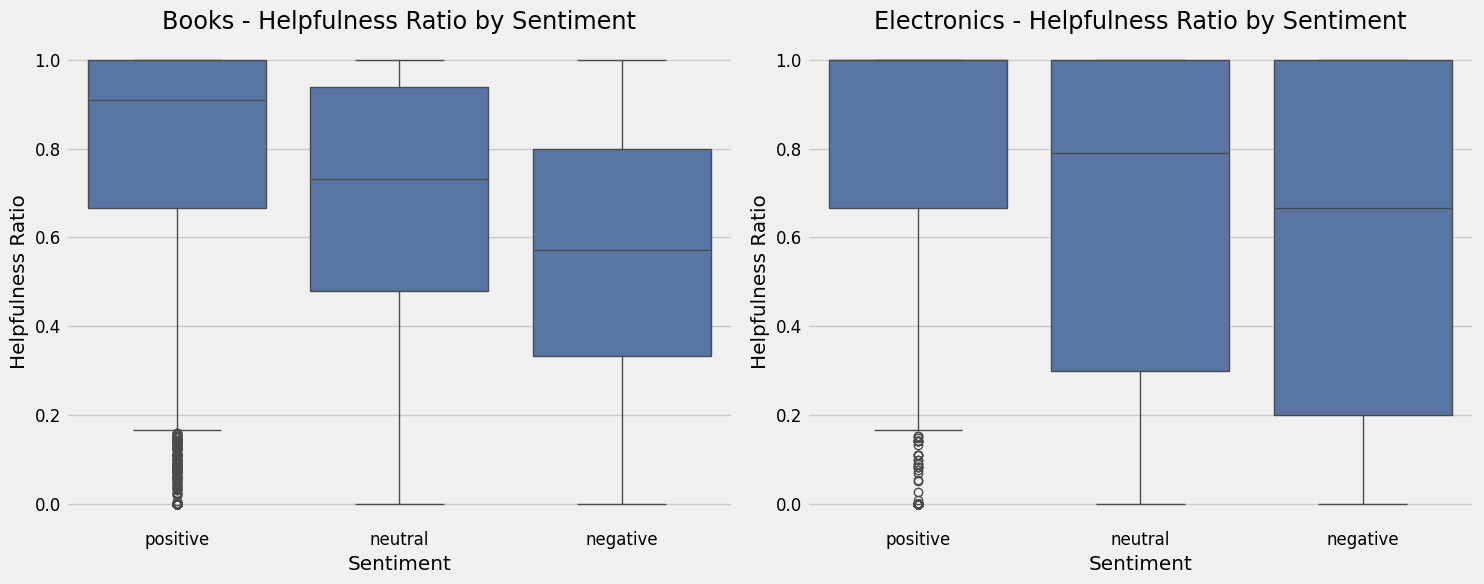

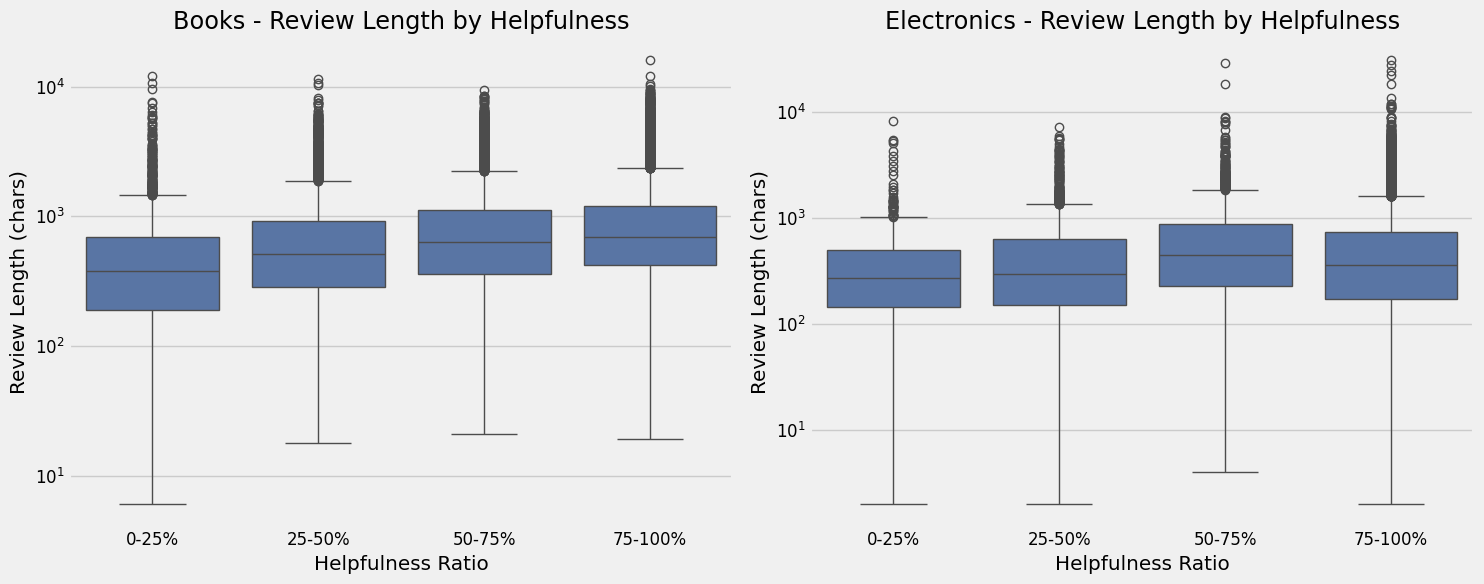

In [25]:
# Calculate class distribution percentages
def plot_category_sentiment_comparison():
    # Calculate percentages for better comparison
    books_sentiment_counts = books_processed['sentiment'].value_counts(normalize=True) * 100
    electronics_sentiment_counts = electronics_processed['sentiment'].value_counts(normalize=True) * 100
    
    # Combine into dataframe for plotting
    sentiment_comparison = pd.DataFrame({
        'Books': books_sentiment_counts,
        'Electronics': electronics_sentiment_counts
    })
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    sentiment_comparison.plot(kind='bar')
    plt.title('Sentiment Distribution Comparison Between Categories')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Sentiment')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add percentage labels on bars
    for i, category in enumerate(['Books', 'Electronics']):
        for j, sentiment in enumerate(sentiment_comparison.index):
            plt.text(j + (i-0.5)*0.4, sentiment_comparison.loc[sentiment, category] + 1, 
                    f'{sentiment_comparison.loc[sentiment, category]:.1f}%',
                    ha='center', va='bottom', fontsize=9)
    
    plt.legend(title='Category')
    plt.tight_layout()
    plt.show()

# Plot sentiment comparison
plot_category_sentiment_comparison()

# Analyze helpfulness by sentiment
def plot_helpfulness_by_sentiment():
    plt.figure(figsize=(15, 6))
    
    # Books
    plt.subplot(1, 2, 1)
    sns.boxplot(x='sentiment', y='helpfulness_ratio', data=books_processed[books_processed['total_votes'] > 0])
    plt.title('Books - Helpfulness Ratio by Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Helpfulness Ratio')
    
    # Electronics
    plt.subplot(1, 2, 2)
    sns.boxplot(x='sentiment', y='helpfulness_ratio', data=electronics_processed[electronics_processed['total_votes'] > 0])
    plt.title('Electronics - Helpfulness Ratio by Sentiment')
    plt.xlabel('Sentiment')
    plt.ylabel('Helpfulness Ratio')
    
    plt.tight_layout()
    plt.show()

# Plot helpfulness by sentiment
plot_helpfulness_by_sentiment()

# Analyze review length vs. helpfulness
def plot_review_length_vs_helpfulness():
    # Calculate review length
    books_processed['review_length'] = books_processed['review_body'].fillna('').apply(len)
    electronics_processed['review_length'] = electronics_processed['review_body'].fillna('').apply(len)
    
    # Bin helpfulness ratio
    for df in [books_processed, electronics_processed]:
        df['helpfulness_bin'] = pd.cut(df['helpfulness_ratio'], 
                                       bins=[0, 0.25, 0.5, 0.75, 1.0],
                                       labels=['0-25%', '25-50%', '50-75%', '75-100%'])
    
    # Plot
    plt.figure(figsize=(15, 6))
    
    # Books
    plt.subplot(1, 2, 1)
    sns.boxplot(x='helpfulness_bin', y='review_length', data=books_processed[books_processed['total_votes'] > 0])
    plt.title('Books - Review Length by Helpfulness')
    plt.xlabel('Helpfulness Ratio')
    plt.ylabel('Review Length (chars)')
    plt.yscale('log')
    
    # Electronics
    plt.subplot(1, 2, 2)
    sns.boxplot(x='helpfulness_bin', y='review_length', data=electronics_processed[electronics_processed['total_votes'] > 0])
    plt.title('Electronics - Review Length by Helpfulness')
    plt.xlabel('Helpfulness Ratio')
    plt.ylabel('Review Length (chars)')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

# Plot review length vs helpfulness
plot_review_length_vs_helpfulness()

### Aspect-based Sentiment Analysis

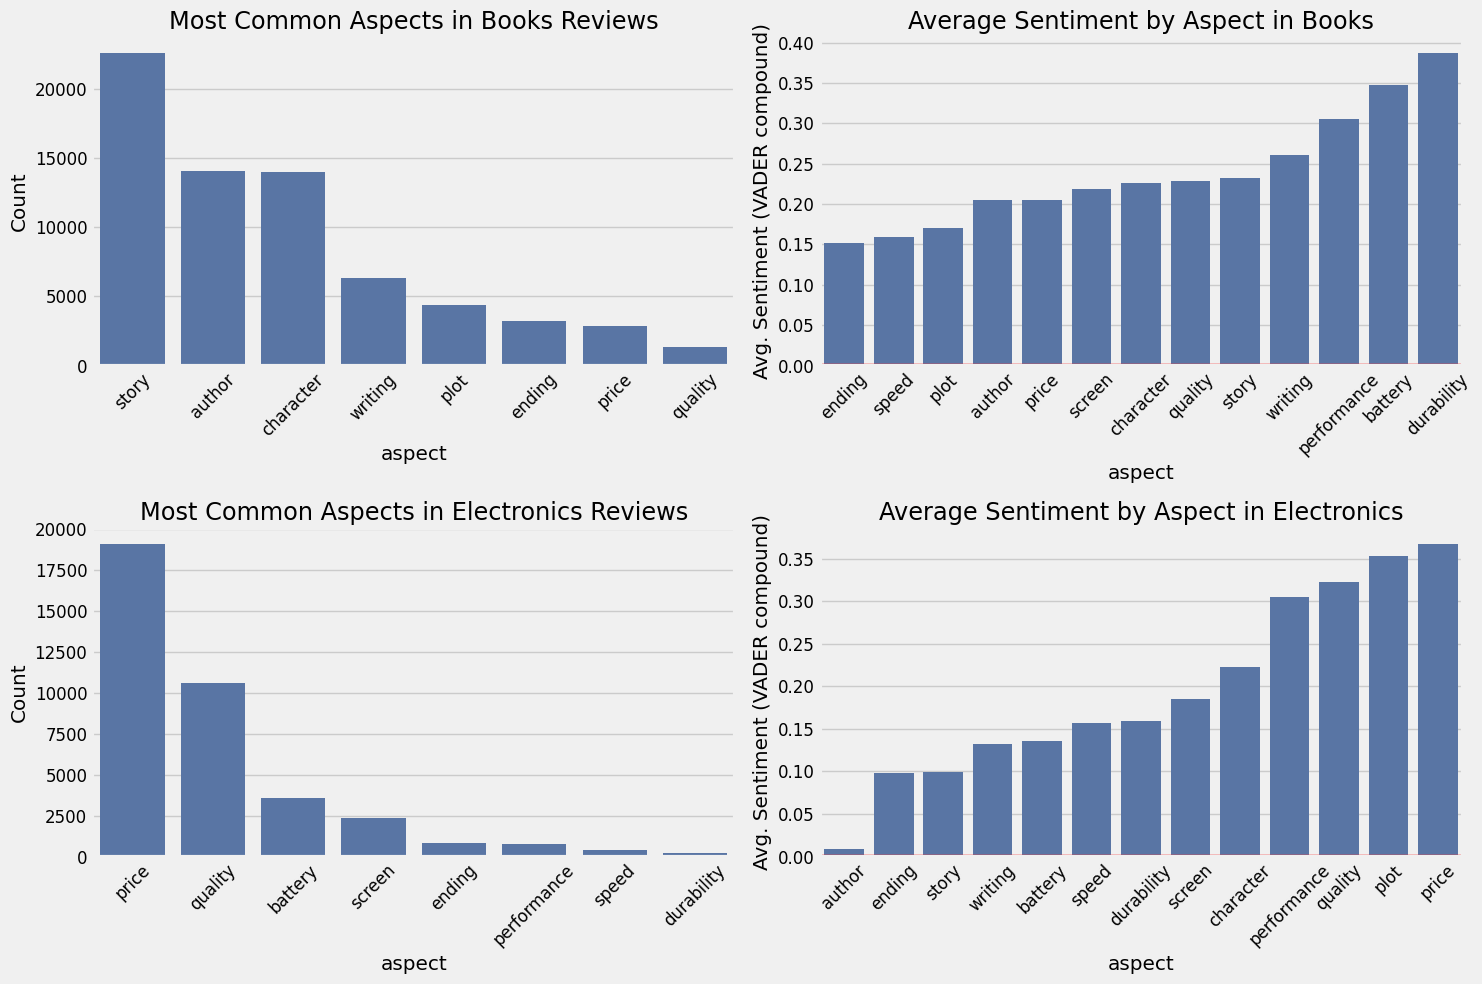

In [26]:
def analyze_aspects():
    # Perform VADER sentiment analysis on reviews with aspects
    sid = SentimentIntensityAnalyzer()
    
    # Extract aspect-sentiment pairs
    books_aspects = []
    for _, row in books_processed.iterrows():
        if pd.isna(row['review_body']) or not row['aspects']:
            continue
            
        text = row['review_body']
        for aspect in row['aspects']:
            # Find sentences containing this aspect
            sentences = re.split(r'[.!?]', text)
            for sentence in sentences:
                if aspect in sentence.lower():
                    sentiment = sid.polarity_scores(sentence)
                    books_aspects.append({
                        'aspect': aspect,
                        'sentiment_compound': sentiment['compound'],
                        'sentiment_category': row['sentiment'],
                        'sentence': sentence.strip()
                    })
    
    electronics_aspects = []
    for _, row in electronics_processed.iterrows():
        if pd.isna(row['review_body']) or not row['aspects']:
            continue
            
        text = row['review_body']
        for aspect in row['aspects']:
            # Find sentences containing this aspect
            sentences = re.split(r'[.!?]', text)
            for sentence in sentences:
                if aspect in sentence.lower():
                    sentiment = sid.polarity_scores(sentence)
                    electronics_aspects.append({
                        'aspect': aspect,
                        'sentiment_compound': sentiment['compound'],
                        'sentiment_category': row['sentiment'],
                        'sentence': sentence.strip()
                    })
    
    # Convert to dataframes
    books_aspects_df = pd.DataFrame(books_aspects)
    electronics_aspects_df = pd.DataFrame(electronics_aspects)
    
    # Plot aspect sentiment analysis
    plt.figure(figsize=(15, 10))
    
    # Only proceed if we found aspects
    if not books_aspects_df.empty:
        plt.subplot(2, 2, 1)
        aspect_counts = books_aspects_df['aspect'].value_counts().head(8)
        sns.barplot(x=aspect_counts.index, y=aspect_counts.values)
        plt.title('Most Common Aspects in Books Reviews')
        plt.xticks(rotation=45)
        plt.ylabel('Count')
        
        plt.subplot(2, 2, 2)
        aspect_sentiment = books_aspects_df.groupby('aspect')['sentiment_compound'].mean().sort_values()
        sns.barplot(x=aspect_sentiment.index, y=aspect_sentiment.values)
        plt.title('Average Sentiment by Aspect in Books')
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        plt.xticks(rotation=45)
        plt.ylabel('Avg. Sentiment (VADER compound)')
    
    if not electronics_aspects_df.empty:
        plt.subplot(2, 2, 3)
        aspect_counts = electronics_aspects_df['aspect'].value_counts().head(8)
        sns.barplot(x=aspect_counts.index, y=aspect_counts.values)
        plt.title('Most Common Aspects in Electronics Reviews')
        plt.xticks(rotation=45)
        plt.ylabel('Count')
        
        plt.subplot(2, 2, 4)
        aspect_sentiment = electronics_aspects_df.groupby('aspect')['sentiment_compound'].mean().sort_values()
        sns.barplot(x=aspect_sentiment.index, y=aspect_sentiment.values)
        plt.title('Average Sentiment by Aspect in Electronics')
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        plt.xticks(rotation=45)
        plt.ylabel('Avg. Sentiment (VADER compound)')
    
    plt.tight_layout()
    plt.show()
    
    return books_aspects_df, electronics_aspects_df

# Run aspect analysis
books_aspects_df, electronics_aspects_df = analyze_aspects()

###  Topic Modeling with LDA


=== Books Review Topics ===
Topic 0: book br information use good great work new books read
Topic 1: book read like just br good really books reading time
Topic 2: br history world war people american god life political america
Topic 3: quot br recipes food collection music like new amp poetry
Topic 4: br story life characters novel love book read character series


<Figure size 1400x600 with 0 Axes>

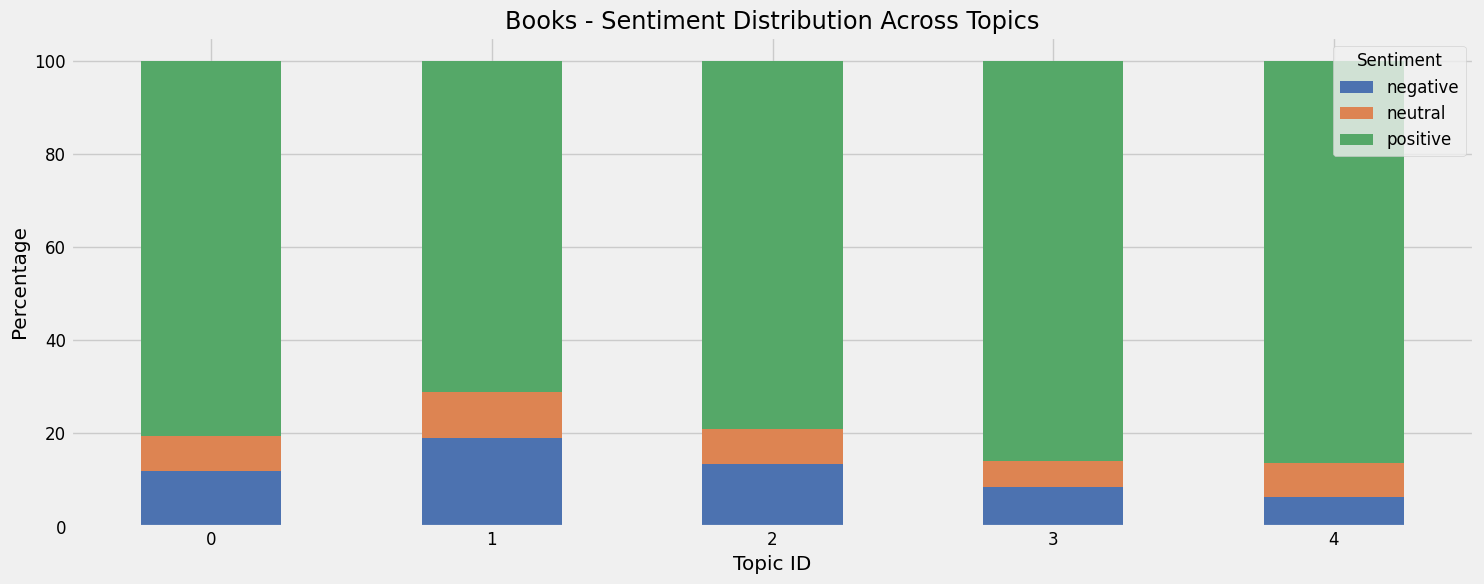


=== Electronics Review Topics ===
Topic 0: br sound headphones good great quality music like use ear
Topic 1: br tv remote power 34 use battery device batteries wall
Topic 2: great product works cable work good just price worked buy
Topic 3: speakers audio receiver sound br high end wire cable run
Topic 4: radio ipod antenna cd bought time unit old clock like


<Figure size 1400x600 with 0 Axes>

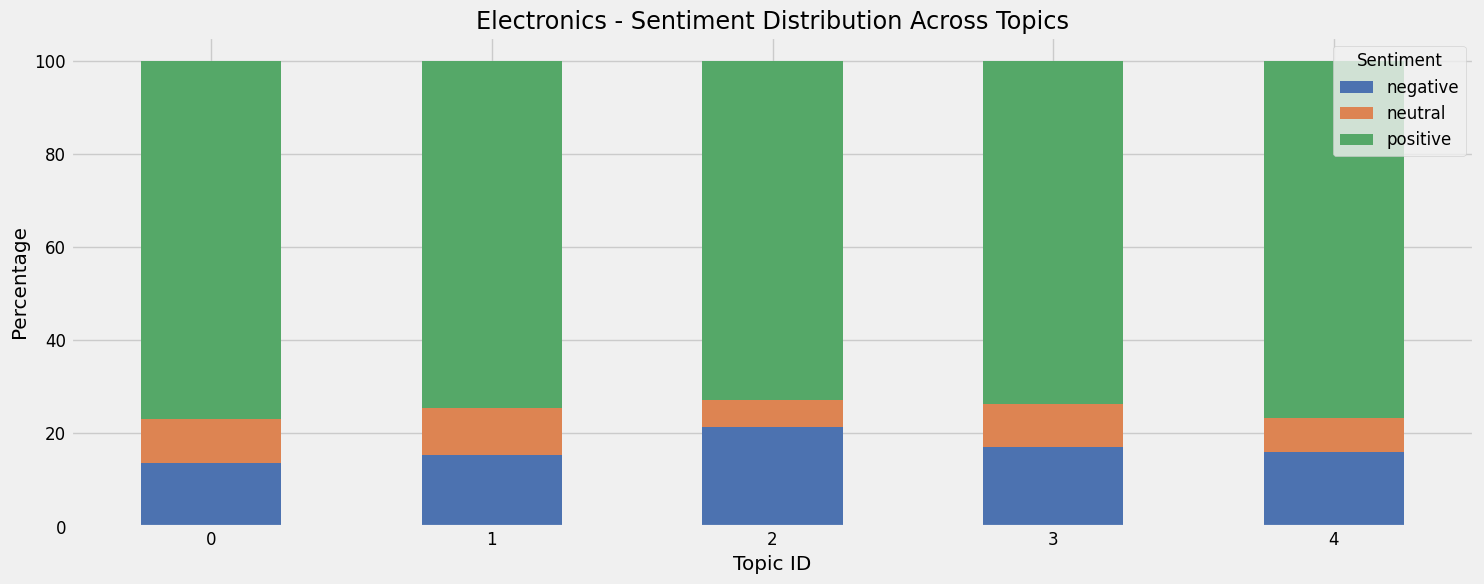

In [27]:
# Cell 6: Topic Modeling with LDA - Fixed Version
def perform_topic_modeling(category_df, category_name, num_topics=5):
    # Prepare text data
    reviews = category_df['review_body'].fillna('').astype(str).tolist()
    
    # Vectorize text - FIX: Use 'english' as a string instead of a set of stopwords
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    X = vectorizer.fit_transform(reviews)
    
    # Train LDA model
    lda = LatentDirichletAllocation(
        n_components=num_topics,
        max_iter=10,
        learning_method='online',
        random_state=42
    )
    lda.fit(X)
    
    # Get top words for each topic
    feature_names = vectorizer.get_feature_names_out()
    topic_summaries = []
    
    print(f"\n=== {category_name} Review Topics ===")
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-11:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topic_summaries.append({
            'topic_id': topic_idx,
            'top_words': top_words
        })
        print(f"Topic {topic_idx}: {' '.join(top_words)}")
    
    # Assign topics to reviews
    topic_assignments = lda.transform(X)
    category_df['dominant_topic'] = topic_assignments.argmax(axis=1)
    
    # Analyze sentiment distribution across topics
    topic_sentiment = category_df.groupby(['dominant_topic', 'sentiment']).size().unstack(fill_value=0)
    topic_sentiment_pct = topic_sentiment.div(topic_sentiment.sum(axis=1), axis=0) * 100
    
    # Plot topic-sentiment distribution
    plt.figure(figsize=(14, 6))
    topic_sentiment_pct.plot(kind='bar', stacked=True)
    plt.title(f'{category_name} - Sentiment Distribution Across Topics')
    plt.xlabel('Topic ID')
    plt.ylabel('Percentage')
    plt.xticks(rotation=0)
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()
    
    return topic_summaries, lda, vectorizer

# Perform topic modeling for both categories
books_topics, books_lda, books_vectorizer = perform_topic_modeling(books_processed, 'Books')
electronics_topics, electronics_lda, electronics_vectorizer = perform_topic_modeling(electronics_processed, 'Electronics')

### Balance the Datasets

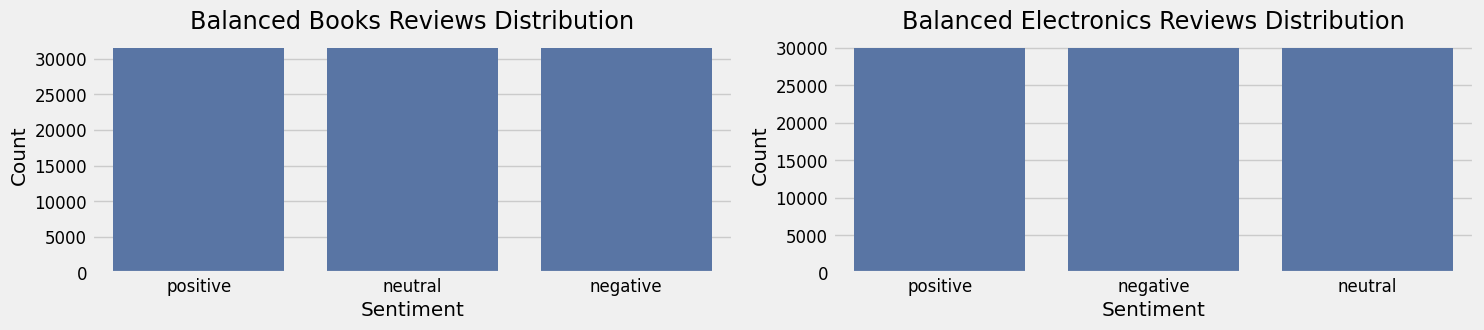

Class weights for Books: {0: 2.551541130843029, 1: 4.028684231729917, 2: 0.4237539515055978}
Class weights for Electronics: {0: 1.935508845275423, 1: 4.233341800016933, 2: 0.44501406244437325}


In [33]:
def balance_dataset(df, strategy='oversample'):
    # Count samples in each class
    class_counts = df['sentiment'].value_counts()
    min_class_count = class_counts.min()
    
    # Create a balanced dataset by sampling from each class
    balanced_df = pd.DataFrame()
    
    if strategy == 'undersample':
        # Undersample majority classes
        for sentiment in df['sentiment'].unique():
            class_df = df[df['sentiment'] == sentiment]
            # If this class has more samples than the minority class, undersample it
            if len(class_df) > min_class_count:
                class_df = class_df.sample(min_class_count, random_state=42)
            balanced_df = pd.concat([balanced_df, class_df])
    
    elif strategy == 'oversample':
        # Oversample minority classes and slightly undersample majority
        max_class_count = class_counts.max()
        target_count = int(max_class_count * 0.8)  # 80% of majority class
        
        for sentiment in df['sentiment'].unique():
            class_df = df[df['sentiment'] == sentiment]
            if len(class_df) < target_count:
                # Oversample with replacement
                class_df = class_df.sample(target_count, replace=True, random_state=42)
            else:
                # Slightly undersample
                class_df = class_df.sample(target_count, random_state=42)
            balanced_df = pd.concat([balanced_df, class_df])
    
    return balanced_df

# Create balanced datasets
books_balanced = balance_dataset(books_processed, strategy='oversample')
electronics_balanced = balance_dataset(electronics_processed, strategy='oversample')

# Visualize balanced distributions
plt.figure(figsize=(15, 6))
plt.subplot(2, 2, 1)
sns.countplot(x='sentiment', data=books_balanced)
plt.title('Balanced Books Reviews Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.subplot(2, 2, 2)
sns.countplot(x='sentiment', data=electronics_balanced)
plt.title('Balanced Electronics Reviews Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Calculate class weights for weighted loss function
def calculate_class_weights(df):
    class_counts = df['sentiment'].value_counts()
    total = len(df)
    class_weights = {}
    labels = {'negative': 0, 'neutral': 1, 'positive': 2}
    
    for sentiment, label in labels.items():
        class_weights[label] = total / (len(labels) * class_counts.get(sentiment, 1))
    
    return class_weights

books_weights = calculate_class_weights(books_processed)
electronics_weights = calculate_class_weights(electronics_processed)

print("Class weights for Books:", books_weights)
print("Class weights for Electronics:", electronics_weights)

### Model Comparisons (BERT vs DistilBERT vs Traditional ML)

In [34]:
# Load BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_for_bert(examples, tokenizer, max_length=512):
    # Combine headline and review body for better context
    texts = []
    for headline, body in zip(examples['review_headline'], examples['review_body']):
        # Handle NaN values
        headline = "" if pd.isna(headline) else str(headline)
        body = "" if pd.isna(body) else str(body)
        
        # Combine with [SEP] token between headline and body
        text = headline + " [SEP] " + body
        texts.append(text)
        
    # Return dictionary with tensors
    return tokenizer(
        texts, 
        padding="max_length", 
        truncation=True, 
        max_length=max_length,
        return_tensors="pt"
    )

def prepare_datasets(df, tokenizer, label_col='sentiment'):
    # Map sentiment to numeric labels
    sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    df['label'] = df[label_col].map(sentiment_map)
    
    # Split data
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    
    # Convert to HF datasets
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_df)
    
    # Tokenize
    train_tokenized = train_dataset.map(
        lambda examples: tokenize_for_bert(examples, tokenizer), 
        batched=True
    )
    val_tokenized = val_dataset.map(
        lambda examples: tokenize_for_bert(examples, tokenizer), 
        batched=True
    )
    test_tokenized = test_dataset.map(
        lambda examples: tokenize_for_bert(examples, tokenizer), 
        batched=True
    )
    
    # Format datasets
    cols_to_remove = ['sentiment', 'product_title', 'review_headline', 'review_body', 
                      'verified_purchase', 'star_rating', 'helpful_votes', 'total_votes',
                      'helpfulness_ratio', 'aspects', 'dominant_topic']
    cols_to_remove = [col for col in cols_to_remove if col in train_tokenized.column_names]
    
    train_tokenized = train_tokenized.remove_columns(cols_to_remove)
    train_tokenized = train_tokenized.rename_column('label', 'labels')
    train_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    
    val_tokenized = val_tokenized.remove_columns(cols_to_remove)
    val_tokenized = val_tokenized.rename_column('label', 'labels')
    val_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    
    test_tokenized = test_tokenized.remove_columns(cols_to_remove)
    test_tokenized = test_tokenized.rename_column('label', 'labels')
    test_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    
    return train_tokenized, val_tokenized, test_tokenized

print("Preparing datasets for BERT...")
books_bert_train, books_bert_val, books_bert_test = prepare_datasets(
    books_balanced, bert_tokenizer
)

electronics_bert_train, electronics_bert_val, electronics_bert_test = prepare_datasets(
    electronics_balanced, bert_tokenizer
)

print("Preparing datasets for DistilBERT...")
books_distilbert_train, books_distilbert_val, books_distilbert_test = prepare_datasets(
    books_balanced, distilbert_tokenizer
)

electronics_distilbert_train, electronics_distilbert_val, electronics_distilbert_test = prepare_datasets(
    electronics_balanced, distilbert_tokenizer
)

Preparing datasets for BERT...


Map: 100%|██████████| 13483/13483 [00:15<00:00, 868.88 examples/s]


Preparing datasets for DistilBERT...


Map: 100%|██████████| 13483/13483 [00:14<00:00, 921.31 examples/s]


### Define the Weighted Loss Trainer and evaluation metrics

In [35]:
class WeightedLossTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Modified compute_loss method that properly handles DataParallel models
        and converts tensor dtypes to match model expectations
        """
        if hasattr(inputs, "labels"):
            labels = inputs.labels
        else:
            labels = inputs.pop("labels")
            
        # Convert inputs to float32 if needed
        for k, v in inputs.items():
            if isinstance(v, torch.Tensor) and v.dtype == torch.float64:
                inputs[k] = v.float()  # Convert from float64 to float32
            
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Access model.module.config for DataParallel models
        if hasattr(model, "module"):
            num_labels = model.module.config.num_labels
        else:
            num_labels = model.config.num_labels
        
        if self.class_weights is not None:
            # Convert weights dict to tensor with correct dtype
            weight_tensor = torch.tensor(
                [self.class_weights[i] for i in range(len(self.class_weights))], 
                device=logits.device,
                dtype=torch.float32  # Explicitly set dtype to float32
            )
            loss_fct = torch.nn.CrossEntropyLoss(weight=weight_tensor)
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
            
        # Ensure compatible dtypes
        if logits.dtype != labels.dtype and labels.dtype == torch.int64:
            # This is fine, labels should be integers (long)
            pass
        elif logits.dtype != labels.dtype:
            # If types don't match and it's not the normal int/float case, convert labels
            labels = labels.to(logits.dtype)
            
        loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

# Comprehensive evaluation metrics including IR metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Classification metrics
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")
    precision = evaluate.load("precision")
    recall = evaluate.load("recall")
    
    # IR metrics
    # Calculate probabilities
    probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
    
    # Prepare data for nDCG
    ndcg_scores = []
    ap_scores = []
    for i in range(len(predictions)):
        # Convert one-hot labels for ndcg
        one_hot = np.zeros(3)
        one_hot[labels[i]] = 1
        ndcg_scores.append(ndcg_score(np.array([one_hot]), np.array([probs[i]])))
        
        # For MAP, use binary relevance
        relevant_class = labels[i]
        relevance = [1 if j == relevant_class else 0 for j in range(3)]
        ap_scores.append(average_precision_score(relevance, probs[i]))
    
    return {
        'accuracy': accuracy.compute(predictions=predictions, references=labels)['accuracy'],
        'f1_macro': f1.compute(predictions=predictions, references=labels, average='macro')['f1'],
        'precision_macro': precision.compute(predictions=predictions, references=labels, average='macro')['precision'],
        'recall_macro': recall.compute(predictions=predictions, references=labels, average='macro')['recall'],
        'ndcg': np.mean(ndcg_scores),
        'map': np.mean(ap_scores)
    }

### Training Functions for Different Models

In [36]:
# Function to train BERT model
def train_bert_model(train_dataset, val_dataset, test_dataset, class_weights, category, model_type='bert'):
    # Load appropriate model and tokenizer
    if model_type == 'bert':
        model_name = "bert-base-uncased"
        model = BertForSequenceClassification.from_pretrained(
            model_name, 
            num_labels=3,
            torch_dtype=torch.float32
        )
    else:  # 'distilbert'
        model_name = "distilbert-base-uncased"
        model = DistilBertForSequenceClassification.from_pretrained(
            model_name, 
            num_labels=3,
            torch_dtype=torch.float32
        )
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"{category}_{model_type}_model",
        learning_rate=3e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        gradient_accumulation_steps=1,
        num_train_epochs=3,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        push_to_hub=False,
        fp16=True,
        dataloader_num_workers=4,
        logging_steps=50,
        report_to="none",
        warmup_ratio=0.1,
        lr_scheduler_type="cosine",
    )
    
    # Convert class weights to float32
    float32_class_weights = {k: float(v) for k, v in class_weights.items()}
    
    # Initialize the trainer with class weights
    trainer = WeightedLossTrainer(
        class_weights=float32_class_weights,
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )
    
    # Train the model
    print(f"Training {category} {model_type} model...")
    trainer.train()
    
    # Save the final model
    model_path = f"{category}_{model_type}_model_final"
    trainer.save_model(model_path)
    print(f"Model saved to {model_path}")
    
    # Evaluate on test set
    test_results = trainer.evaluate(test_dataset)
    
    return trainer, model_path, test_results

# Function to train and evaluate traditional ML model (Logistic Regression)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def train_traditional_model(df, category):
    # Prepare data
    X_train, X_test, y_train, y_test = train_test_split(
        df['review_body'].fillna(''),
        df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2}),
        test_size=0.2,
        random_state=42
    )
    
    # Create pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', C=5.0))
    ])
    
    # Train model
    print(f"Training {category} Logistic Regression model...")
    pipeline.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    results = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'precision_macro': precision_score(y_test, y_pred, average='macro'),
        'recall_macro': recall_score(y_test, y_pred, average='macro')
    }
    
    # Save model
    import joblib
    model_path = f"{category}_logistic_regression_model.joblib"
    joblib.dump(pipeline, model_path)
    print(f"Model saved to {model_path}")
    
    return pipeline, results

### Train all models (BERT, DistilBERT, and Logistic Regression)

In [ ]:
import time
results_dict = {}

# Train BERT models
print("Training BERT models (this will take some time)...")
start_time = time.time()

# BERT for Books
print("\n=== Training BERT for Books ===")
books_bert_trainer, books_bert_path, books_bert_results = train_bert_model(
    books_bert_train, books_bert_val, books_bert_test, 
    books_weights, "Books", "bert"
)
results_dict["BERT_Books"] = books_bert_results
print(f"BERT Books model training completed in {(time.time() - start_time)/60:.2f} minutes")

# BERT for Electronics
start_time = time.time()
print("\n=== Training BERT for Electronics ===")
electronics_bert_trainer, electronics_bert_path, electronics_bert_results = train_bert_model(
    electronics_bert_train, electronics_bert_val, electronics_bert_test, 
    electronics_weights, "Electronics", "bert"
)
results_dict["BERT_Electronics"] = electronics_bert_results
print(f"BERT Electronics model training completed in {(time.time() - start_time)/60:.2f} minutes")

# Train DistilBERT models
print("\n=== Training DistilBERT for Books ===")
start_time = time.time()
books_distilbert_trainer, books_distilbert_path, books_distilbert_results = train_bert_model(
    books_distilbert_train, books_distilbert_val, books_distilbert_test, 
    books_weights, "Books", "distilbert"
)
results_dict["DistilBERT_Books"] = books_distilbert_results
print(f"DistilBERT Books model training completed in {(time.time() - start_time)/60:.2f} minutes")

print("\n=== Training DistilBERT for Electronics ===")
start_time = time.time()
electronics_distilbert_trainer, electronics_distilbert_path, electronics_distilbert_results = train_bert_model(
    electronics_distilbert_train, electronics_distilbert_val, electronics_distilbert_test, 
    electronics_weights, "Electronics", "distilbert"
)
results_dict["DistilBERT_Electronics"] = electronics_distilbert_results
print(f"DistilBERT Electronics model training completed in {(time.time() - start_time)/60:.2f} minutes")

# Train traditional ML models (Logistic Regression)
print("\n=== Training Logistic Regression for Books ===")
start_time = time.time()
books_lr_model, books_lr_results = train_traditional_model(books_balanced, "Books")
results_dict["LogisticRegression_Books"] = books_lr_results
print(f"Logistic Regression Books model training completed in {(time.time() - start_time)/60:.2f} minutes")

print("\n=== Training Logistic Regression for Electronics ===")
start_time = time.time()
electronics_lr_model, electronics_lr_results = train_traditional_model(electronics_balanced, "Electronics")
results_dict["LogisticRegression_Electronics"] = electronics_lr_results
print(f"Logistic Regression Electronics model training completed in {(time.time() - start_time)/60:.2f} minutes")

# Save all results
with open('model_comparison_results.json', 'w') as f:
    json.dump(results_dict, f, indent=4)
    
print("\nAll model training completed. Results saved to model_comparison_results.json")

### Visualize and compare model results

Models found in results: ['BERT_Books', 'BERT_Electronics', 'DistilBERT_Books', 'DistilBERT_Electronics', 'LogisticRegression_Books', 'LogisticRegression_Electronics']
Unique algorithms: ['BERT' 'DistilBERT' 'LogisticRegression']
Unique categories: ['Books' 'Electronics']


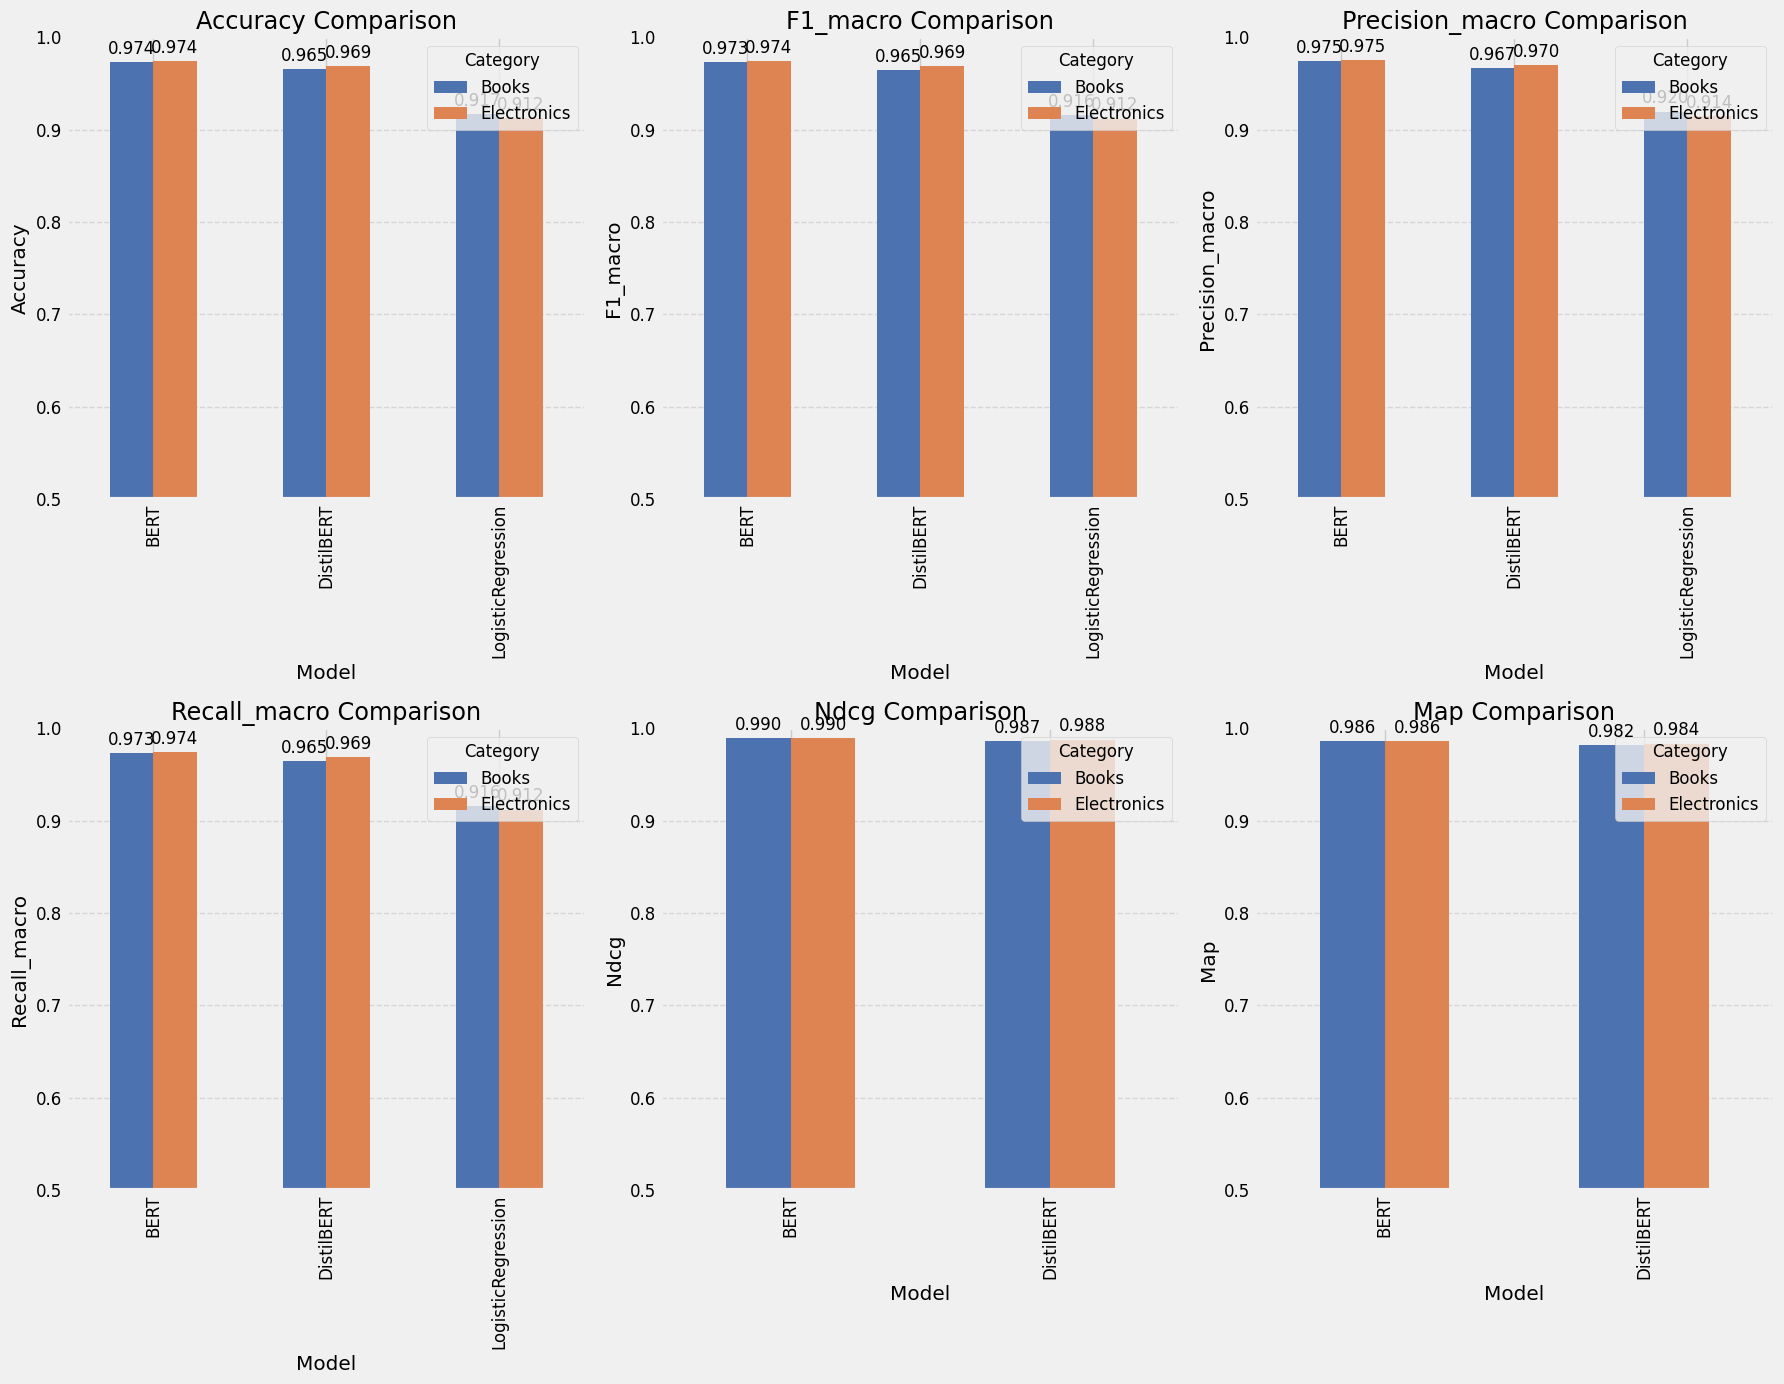

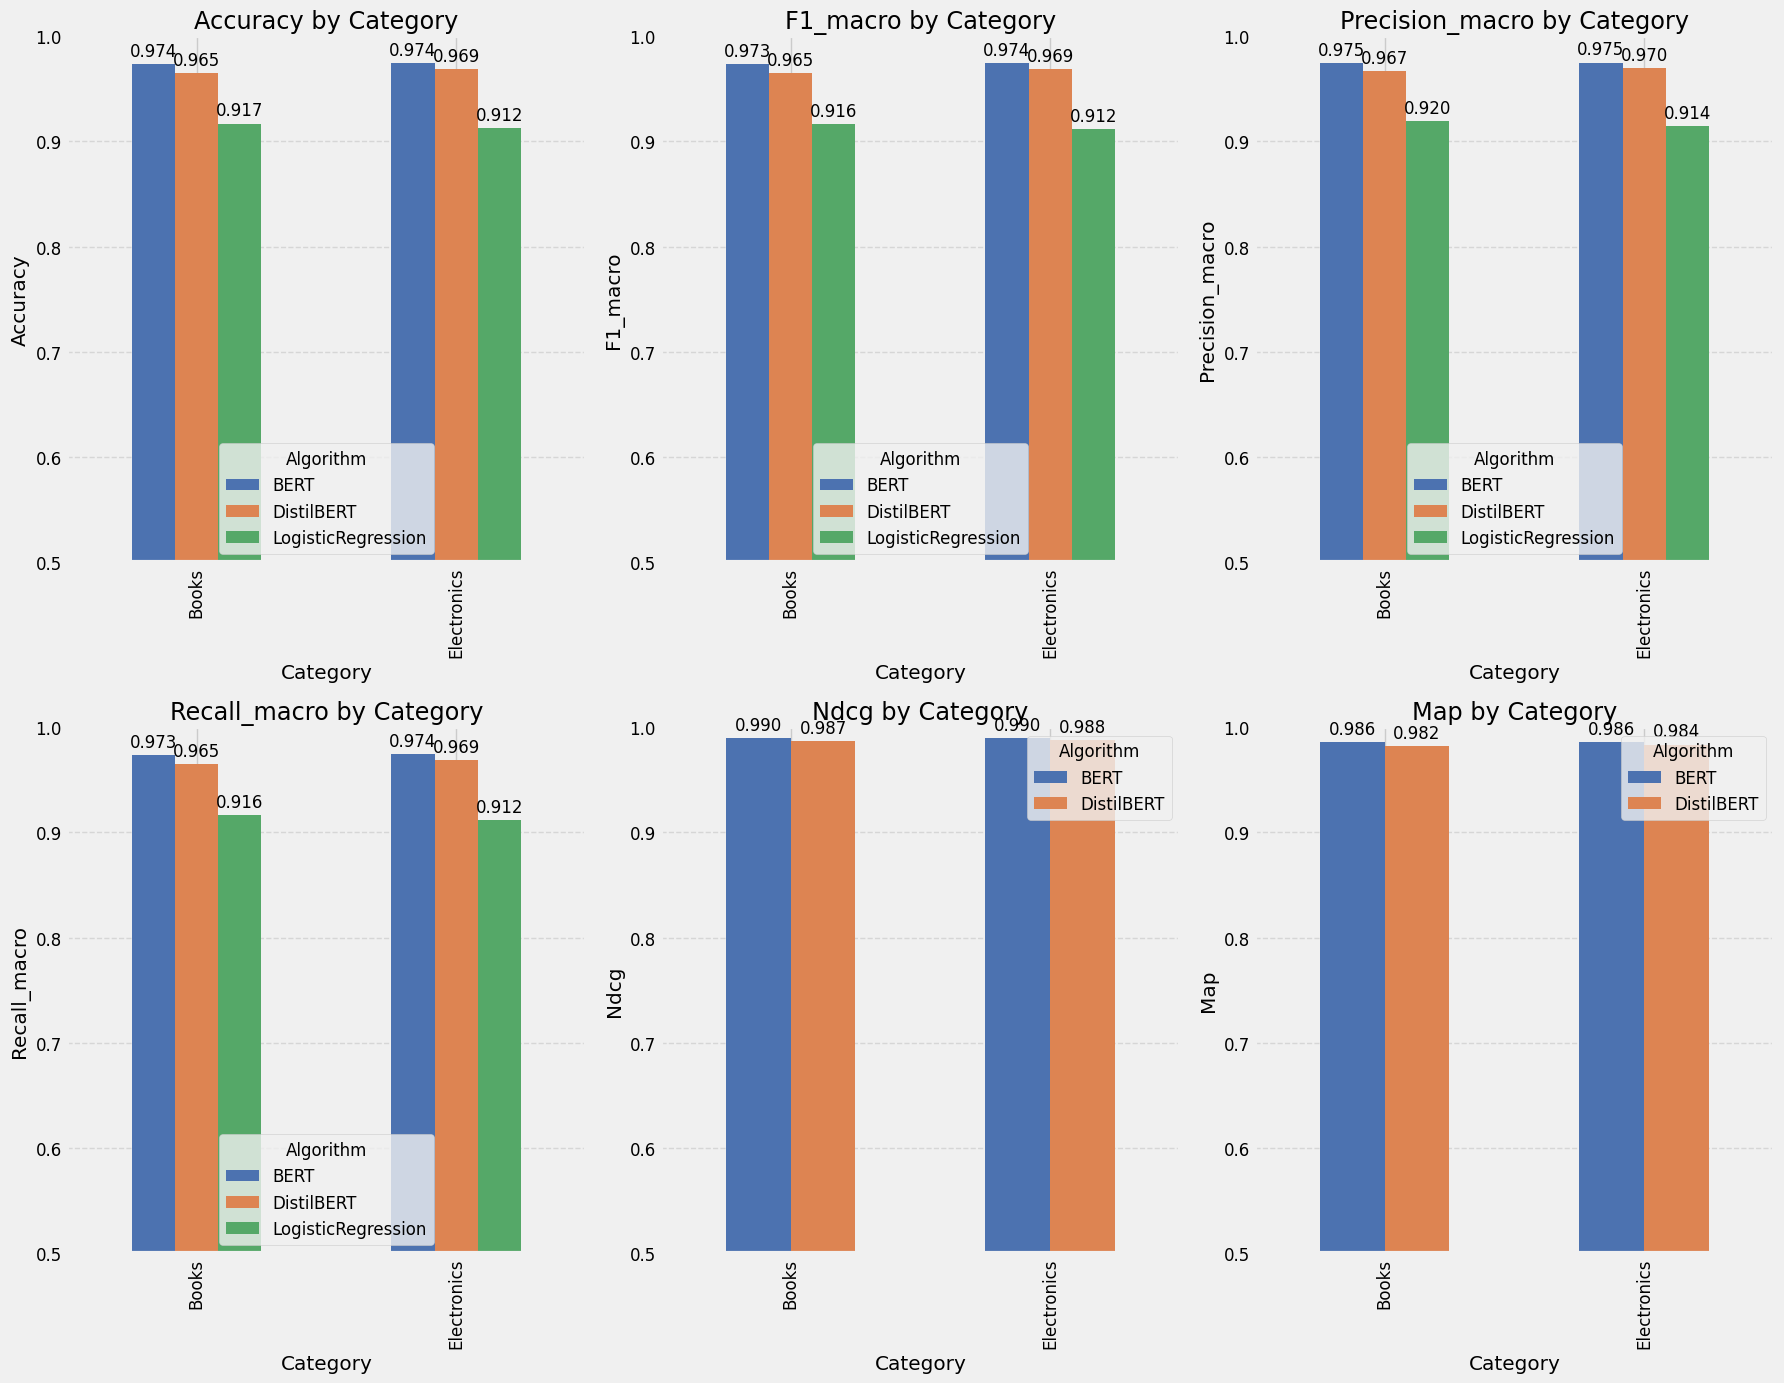

In [44]:
# Fixed visualization function for model comparison
def visualize_model_comparison(results_dict):
    # Check what models we have in results
    models = list(results_dict.keys())
    print(f"Models found in results: {models}")
    
    # Prepare data
    plot_data = []
    for model in models:
        model_parts = model.split('_')
        if len(model_parts) == 2:
            algorithm, category = model_parts
            
            # Handle different metric naming between transformer and traditional models
            if algorithm in ['BERT', 'DistilBERT']:
                # For transformer models, metrics have 'eval_' prefix
                metrics = {
                    'accuracy': results_dict[model].get('eval_accuracy'),
                    'f1_macro': results_dict[model].get('eval_f1_macro'),
                    'precision_macro': results_dict[model].get('eval_precision_macro'),
                    'recall_macro': results_dict[model].get('eval_recall_macro'),
                    'ndcg': results_dict[model].get('eval_ndcg'),
                    'map': results_dict[model].get('eval_map')
                }
            else:
                # For traditional models, metrics don't have prefix
                metrics = {
                    'accuracy': results_dict[model].get('accuracy'),
                    'f1_macro': results_dict[model].get('f1_macro'),
                    'precision_macro': results_dict[model].get('precision_macro'),
                    'recall_macro': results_dict[model].get('recall_macro')
                }
            
            # Add data for plotting
            for metric_name, value in metrics.items():
                if value is not None:
                    plot_data.append({
                        'Model': model,
                        'Metric': metric_name,
                        'Value': value,
                        'Category': category,
                        'Algorithm': algorithm
                    })
    
    df_results = pd.DataFrame(plot_data)
    
    # Check what data we have
    print(f"Unique algorithms: {df_results['Algorithm'].unique()}")
    print(f"Unique categories: {df_results['Category'].unique()}")
    
    # Plotting
    # 1. Compare models across metrics
    plt.figure(figsize=(18, 14))
    
    metrics_to_plot = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
    if 'ndcg' in df_results['Metric'].values:
        metrics_to_plot.extend(['ndcg', 'map'])
    
    for i, metric in enumerate(metrics_to_plot):
        if metric in df_results['Metric'].values:
            plt.subplot(2, 3, i+1)
            
            metric_data = df_results[df_results['Metric'] == metric]
            
            # Create pivot table for plotting
            pivot_data = metric_data.pivot_table(
                index='Algorithm', 
                columns='Category', 
                values='Value'
            )
            
            # Plot grouped bar chart
            ax = pivot_data.plot(kind='bar', ax=plt.gca())
            plt.title(f'{metric.capitalize()} Comparison')
            plt.ylabel(metric.capitalize())
            plt.xlabel('Model')
            plt.legend(title='Category')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.ylim(0.5, 1.0)  # Set y-axis to focus on meaningful differences
            
            # Add value labels
            for j, container in enumerate(plt.gca().containers):
                plt.gca().bar_label(container, fmt='%.3f', padding=3)
    
    plt.tight_layout()
    plt.savefig('model_comparison_metrics.png', dpi=300)
    plt.show()
    
    # 2. Compare categories across models for each metric
    plt.figure(figsize=(18, 14))
    
    for i, metric in enumerate(metrics_to_plot):
        if metric in df_results['Metric'].values:
            plt.subplot(2, 3, i+1)
            
            metric_data = df_results[df_results['Metric'] == metric]
            
            # Create pivot table for plotting (swapped axes)
            pivot_data = metric_data.pivot_table(
                index='Category', 
                columns='Algorithm', 
                values='Value'
            )
            
            # Plot grouped bar chart
            ax = pivot_data.plot(kind='bar', ax=plt.gca())
            plt.title(f'{metric.capitalize()} by Category')
            plt.ylabel(metric.capitalize())
            plt.xlabel('Category')
            plt.legend(title='Algorithm')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.ylim(0.5, 1.0)  # Set y-axis to focus on meaningful differences
            
            # Add value labels
            for j, container in enumerate(plt.gca().containers):
                plt.gca().bar_label(container, fmt='%.3f', padding=3)
    
    plt.tight_layout()
    plt.savefig('model_comparison_by_category.png', dpi=300)
    plt.show()

# Try the fixed visualization function
try:
    with open('model_comparison_results.json', 'r') as f:
        results_dict = json.load(f)
    
    visualize_model_comparison(results_dict)
except Exception as e:
    print(f"Error visualizing results: {e}")

### Predict helpfulness using sentiment features


Training helpfulness prediction model for Books
Mean Squared Error: 0.0881
R² Score: -0.0058


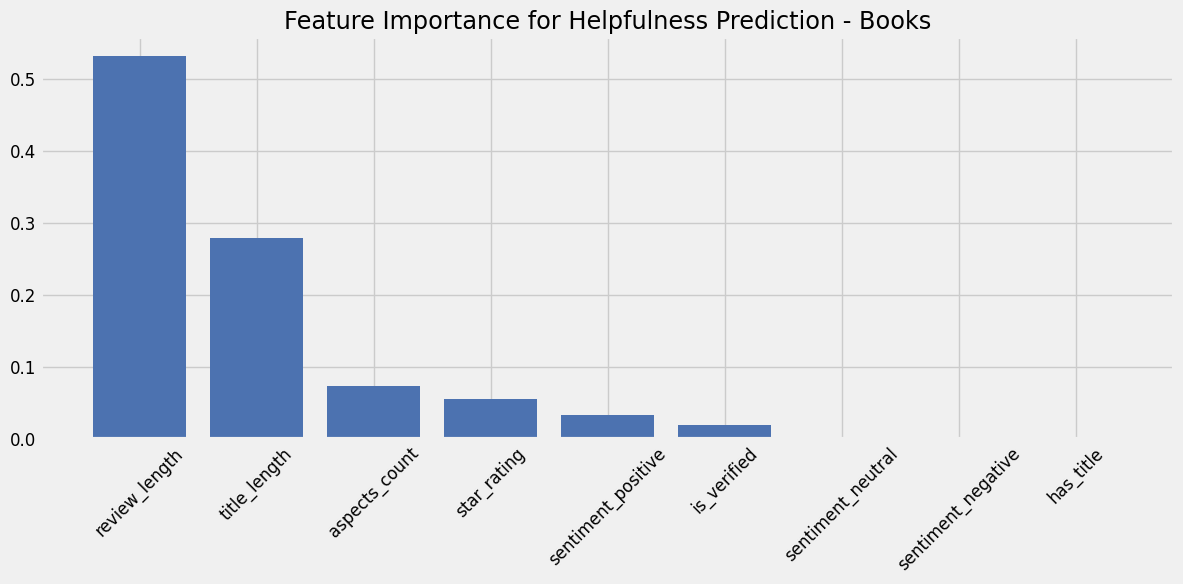

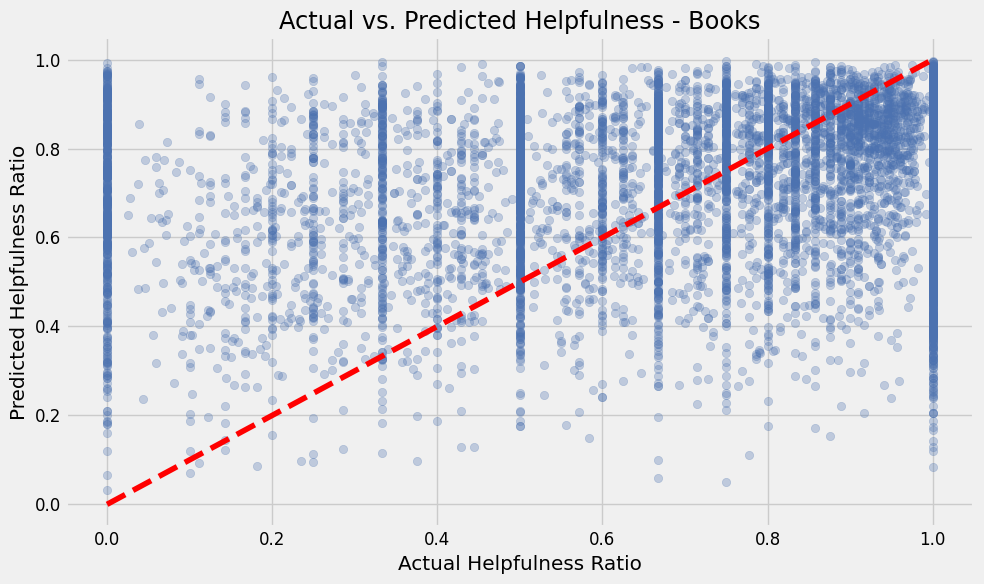


Training helpfulness prediction model for Electronics
Mean Squared Error: 0.1545
R² Score: -0.0515


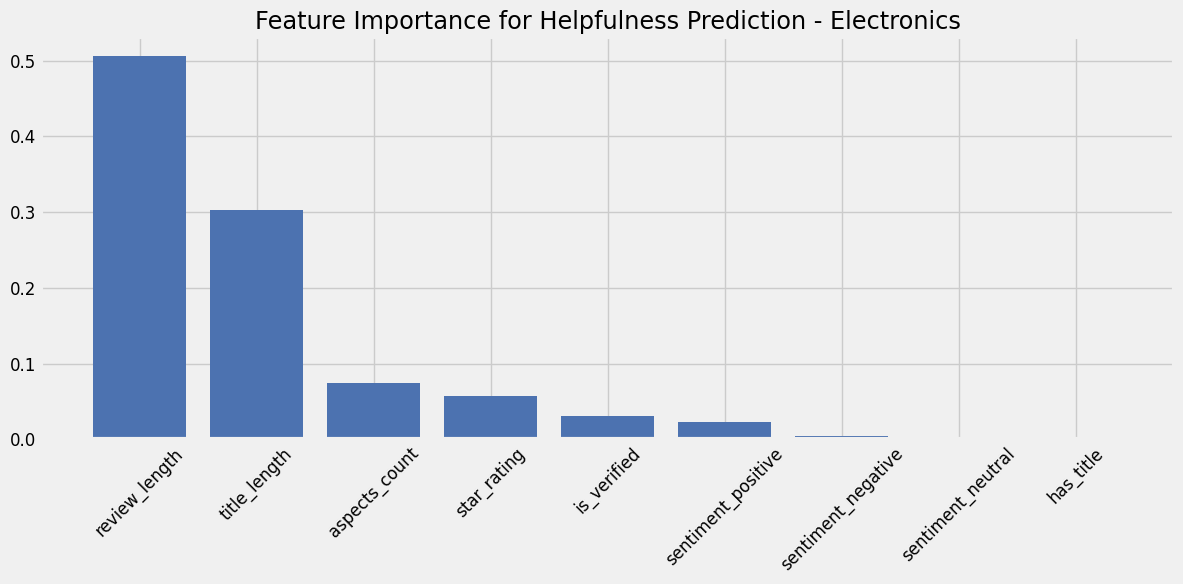

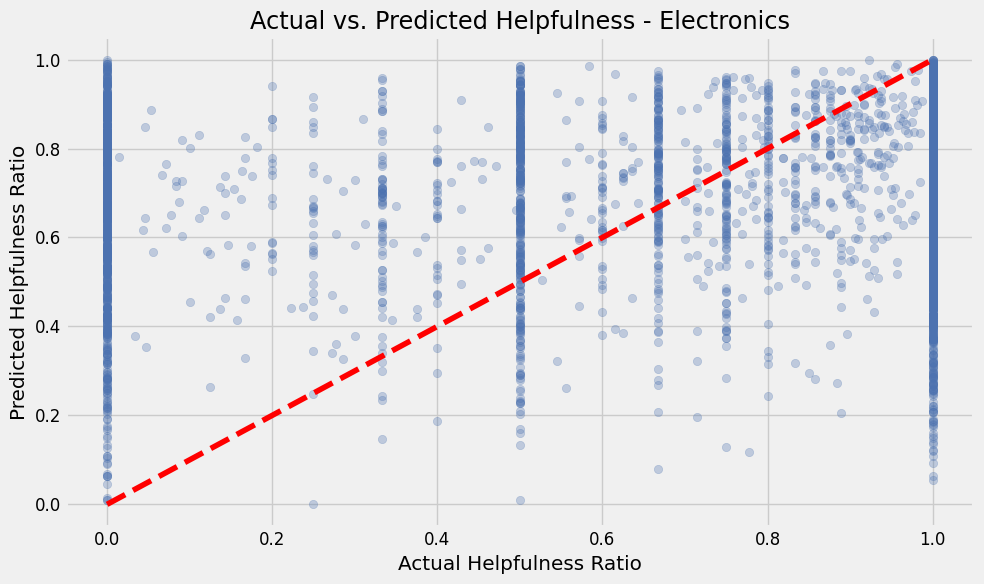

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

def predict_helpfulness():
    # Only use reviews with at least one vote
    books_help = books_processed[books_processed['total_votes'] > 0].copy()
    electronics_help = electronics_processed[electronics_processed['total_votes'] > 0].copy()
    
    # Feature engineering
    for df in [books_help, electronics_help]:
        # One-hot encode sentiment
        sentiment_dummies = pd.get_dummies(df['sentiment'], prefix='sentiment')
        df = pd.concat([df, sentiment_dummies], axis=1)
        
        # Calculate review characteristics
        df['review_length'] = df['review_body'].fillna('').apply(len)
        df['has_title'] = (~df['review_headline'].isna()).astype(int)
        df['title_length'] = df['review_headline'].fillna('').apply(len)
        df['is_verified'] = (df['verified_purchase'] == 'Y').astype(int)
        df['aspects_count'] = df['aspects'].apply(len)
        
        # Calculate the model input features
        X = df[['sentiment_negative', 'sentiment_neutral', 'sentiment_positive', 
                'star_rating', 'review_length', 'has_title', 'title_length', 
                'is_verified', 'aspects_count']]
        
        # Target is helpfulness ratio
        y = df['helpfulness_ratio']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        print(f"\nTraining helpfulness prediction model for {df['category'].iloc[0]}")
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train_scaled, y_train)
        
        # Evaluate model
        y_pred = rf.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"R² Score: {r2:.4f}")
        
        # Feature importance
        features = X.columns
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 6))
        plt.title(f'Feature Importance for Helpfulness Prediction - {df["category"].iloc[0]}')
        plt.bar(range(X.shape[1]), importances[indices], align='center')
        plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Scatter plot of actual vs. predicted
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.3)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlabel('Actual Helpfulness Ratio')
        plt.ylabel('Predicted Helpfulness Ratio')
        plt.title(f'Actual vs. Predicted Helpfulness - {df["category"].iloc[0]}')
        plt.tight_layout()
        plt.show()

# Run helpfulness prediction
predict_helpfulness()

### Create a Simple Prediction Function for the Web App


Sample Book Review Prediction (BERT):
{
  "sentiment": "positive",
  "confidence": 0.9937427639961243,
  "probabilities": {
    "negative": 0.003776677418500185,
    "neutral": 0.0024806137662380934,
    "positive": 0.9937427639961243
  },
  "aspects": {
    "character": {
      "score": -0.6486,
      "sentiment": "negative"
    },
    "ending": {
      "score": -0.6486,
      "sentiment": "negative"
    }
  }
}

Sample Electronics Review Prediction (BERT):
{
  "sentiment": "negative",
  "confidence": 0.9995700716972351,
  "probabilities": {
    "negative": 0.9995700716972351,
    "neutral": 0.0001340573508059606,
    "positive": 0.0002958423865493387
  },
  "aspects": {
    "battery": {
      "score": -0.4215,
      "sentiment": "negative"
    },
    "screen": {
      "score": -0.4215,
      "sentiment": "negative"
    },
    "quality": {
      "score": -0.47354999999999997,
      "sentiment": "negative"
    }
  }
}


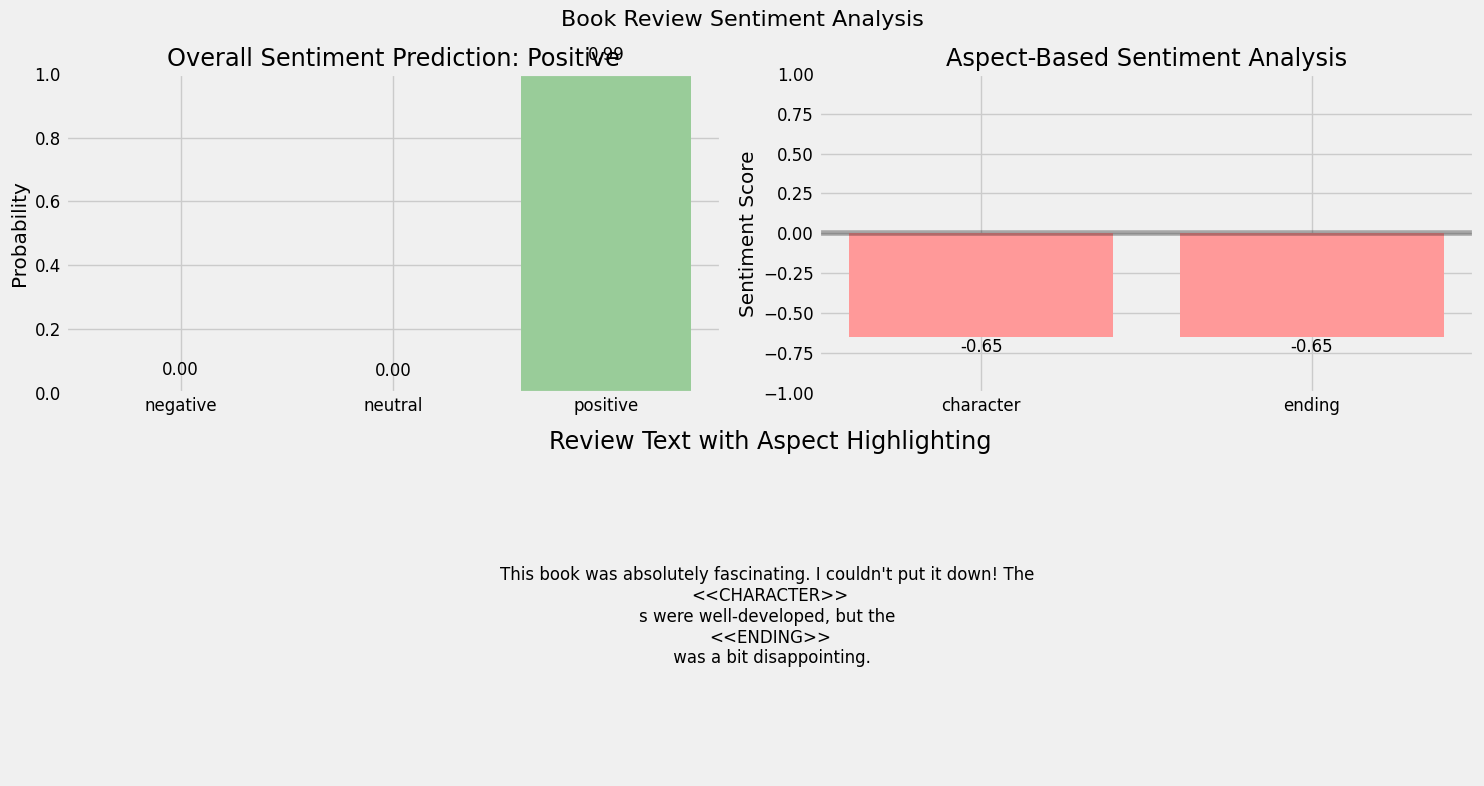

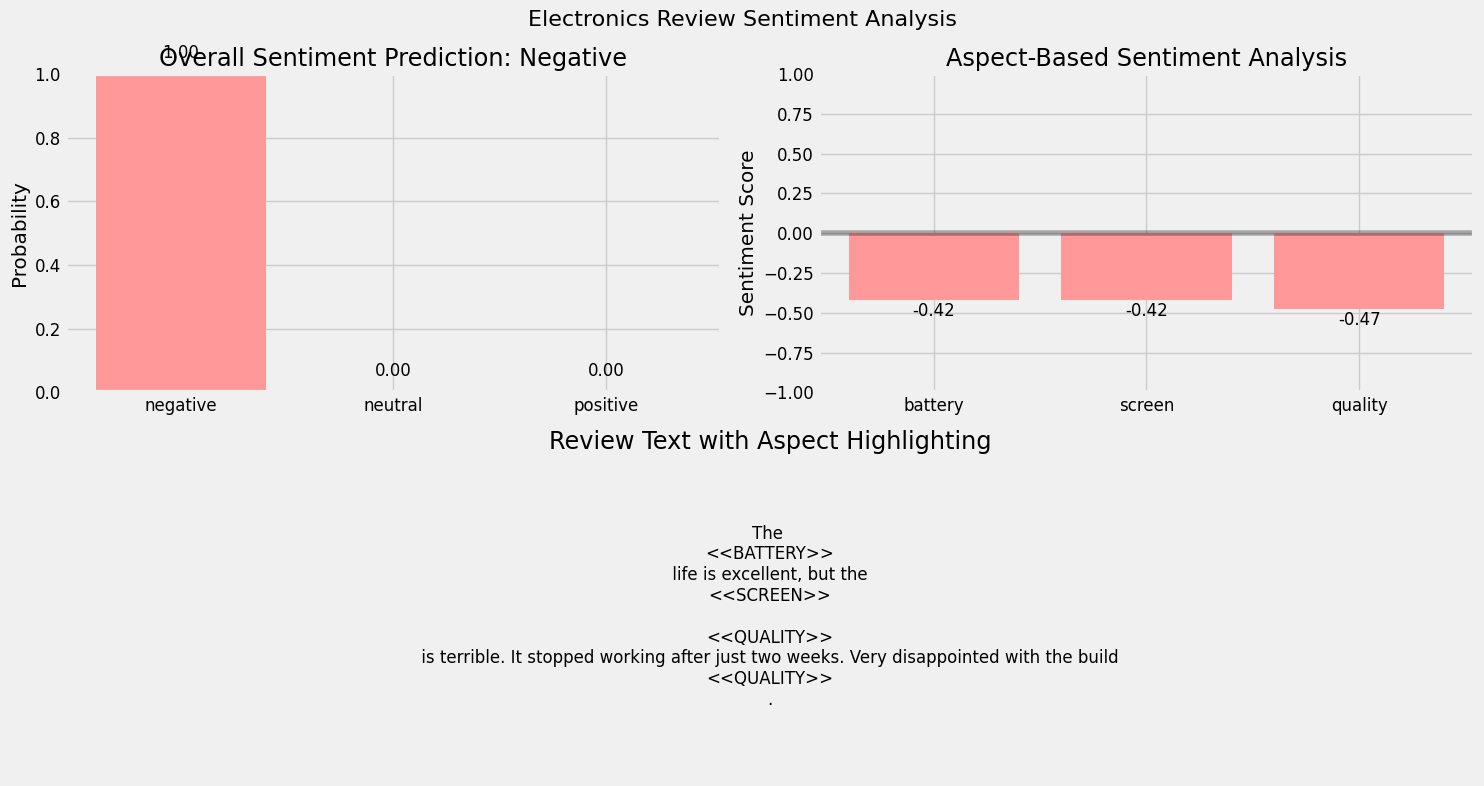

In [46]:
def predict_sentiment(text, category='books', model_type='bert'):
    """
    Function to predict sentiment of a given review text
    """
    # Load the appropriate model and tokenizer
    if model_type == 'bert':
        model_path = f"{category}_{model_type}_model_final"
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        model = BertForSequenceClassification.from_pretrained(model_path)
    elif model_type == 'distilbert':
        model_path = f"{category}_{model_type}_model_final"
        tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        model = DistilBertForSequenceClassification.from_pretrained(model_path)
    else:
        # Load logistic regression model
        import joblib
        model_path = f"{category}_logistic_regression_model.joblib"
        model = joblib.load(model_path)
        
        # For traditional ML, simply return prediction
        prediction_idx = model.predict([text])[0]
        sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
        probas = model.predict_proba([text])[0]
        
        return {
            'sentiment': sentiment_map[prediction_idx],
            'confidence': probas[prediction_idx],
            'probabilities': {
                'negative': probas[0],
                'neutral': probas[1],
                'positive': probas[2]
            }
        }
    
    # For transformer models
    model.eval()
    
    # Tokenize input
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Map outputs to sentiment labels
    sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    predicted_class = torch.argmax(probs, dim=-1).item()
    predicted_sentiment = sentiment_map[predicted_class]
    
    # Extract aspect-based sentiment if available
    aspects = extract_aspects(text)
    aspect_sentiments = {}
    
    if aspects:
        sid = SentimentIntensityAnalyzer()
        sentences = re.split(r'[.!?]', text)
        
        for aspect in aspects:
            aspect_scores = []
            for sentence in sentences:
                if aspect in sentence.lower():
                    score = sid.polarity_scores(sentence)['compound']
                    aspect_scores.append(score)
            
            if aspect_scores:
                aspect_sentiments[aspect] = {
                    'score': sum(aspect_scores) / len(aspect_scores),
                    'sentiment': 'positive' if sum(aspect_scores) / len(aspect_scores) > 0.1 
                                 else ('negative' if sum(aspect_scores) / len(aspect_scores) < -0.1 
                                       else 'neutral')
                }
    
    # Create result dictionary
    result = {
        'sentiment': predicted_sentiment,
        'confidence': probs[0][predicted_class].item(),
        'probabilities': {
            'negative': probs[0][0].item(),
            'neutral': probs[0][1].item(),
            'positive': probs[0][2].item()
        },
        'aspects': aspect_sentiments if aspects else {}
    }
    
    return result

# Test with sample reviews
sample_book_review = "This book was absolutely fascinating. I couldn't put it down! The characters were well-developed, but the ending was a bit disappointing."
sample_electronics_review = "The battery life is excellent, but the screen quality is terrible. It stopped working after just two weeks. Very disappointed with the build quality."

print("\nSample Book Review Prediction (BERT):")
book_result = predict_sentiment(sample_book_review, category='Books', model_type='bert')
print(json.dumps(book_result, indent=2))

print("\nSample Electronics Review Prediction (BERT):")
electronics_result = predict_sentiment(sample_electronics_review, category='Electronics', model_type='bert')
print(json.dumps(electronics_result, indent=2))

# Create visualizations for sample predictions
def visualize_sentiment_prediction(text, result, title):
    plt.figure(figsize=(15, 8))
    
    # Sentiment probabilities
    plt.subplot(2, 2, 1)
    sentiments = list(result['probabilities'].keys())
    probs = list(result['probabilities'].values())
    colors = ['#FF9999', '#FFCC99', '#99CC99']
    plt.bar(sentiments, probs, color=colors)
    plt.title(f'Overall Sentiment Prediction: {result["sentiment"].capitalize()}')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    
    # Add probability values on bars
    for i, prob in enumerate(probs):
        plt.text(i, prob + 0.05, f'{prob:.2f}', ha='center')
    
    # Aspect-based sentiment
    if result['aspects']:
        plt.subplot(2, 2, 2)
        aspects = list(result['aspects'].keys())
        scores = [result['aspects'][aspect]['score'] for aspect in aspects]
        
        # Color code by sentiment
        colors = []
        for aspect in aspects:
            if result['aspects'][aspect]['sentiment'] == 'positive':
                colors.append('#99CC99')  # Green
            elif result['aspects'][aspect]['sentiment'] == 'negative':
                colors.append('#FF9999')  # Red
            else:
                colors.append('#FFCC99')  # Yellow
        
        plt.bar(aspects, scores, color=colors)
        plt.title('Aspect-Based Sentiment Analysis')
        plt.ylabel('Sentiment Score')
        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        plt.ylim(-1, 1)
        
        # Add score values on bars
        for i, score in enumerate(scores):
            plt.text(i, score + 0.1 * (1 if score >= 0 else -1), 
                    f'{score:.2f}', ha='center')
    
    # Display the text with highlighting
    plt.subplot(2, 1, 2)
    plt.axis('off')
    plt.title('Review Text with Aspect Highlighting')
    
    # Format text with highlighted aspects
    formatted_text = text
    if result['aspects']:
        for aspect in result['aspects']:
            color = 'green' if result['aspects'][aspect]['sentiment'] == 'positive' else 'red'
            formatted_text = formatted_text.replace(aspect, f'\n<<{aspect.upper()}>>\n')
    
    plt.text(0.5, 0.5, formatted_text, ha='center', va='center', wrap=True, fontsize=12)
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

# Visualize sample predictions
visualize_sentiment_prediction(sample_book_review, book_result, "Book Review Sentiment Analysis")
visualize_sentiment_prediction(sample_electronics_review, electronics_result, "Electronics Review Sentiment Analysis")

### Create a Web Application Interface

In [ ]:
# !pip install ipywidgets

In [48]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def create_web_interface():
    # Create widgets
    category_dropdown = widgets.Dropdown(
        options=['Books', 'Electronics'],
        value='Books',
        description='Category:',
        style={'description_width': 'initial'}
    )
    
    model_dropdown = widgets.Dropdown(
        options=['bert', 'distilbert', 'logistic_regression'],
        value='bert',
        description='Model:',
        style={'description_width': 'initial'}
    )
    
    review_text = widgets.Textarea(
        value='',
        placeholder='Enter review text here...',
        description='Review:',
        rows=5,
        style={'description_width': 'initial'}
    )
    
    analyze_button = widgets.Button(
        description='Analyze Sentiment',
        button_style='primary',
        tooltip='Click to analyze sentiment'
    )
    
    output = widgets.Output()
    
    # Layout
    header = widgets.HTML(value="<h2>Scam-azon?: Amazon Review Sentiment Analysis</h2>")
    description = widgets.HTML(
        value="""<p>This tool analyzes the sentiment of Amazon product reviews, 
        identifying overall sentiment (positive, negative, neutral) and specific 
        aspects mentioned in the review. Choose a product category and model, then 
        enter your review text and click 'Analyze Sentiment'.</p>"""
    )
    
    # Define button click behavior
    def on_button_click(b):
        with output:
            clear_output()
            
            if not review_text.value.strip():
                print("Please enter review text!")
                return
            
            print(f"Analyzing sentiment for {category_dropdown.value} using {model_dropdown.value} model...")
            result = predict_sentiment(
                review_text.value, 
                category=category_dropdown.value, 
                model_type=model_dropdown.value
            )
            
            print("\nSentiment Analysis Results:")
            print(f"Overall sentiment: {result['sentiment'].upper()} (Confidence: {result['confidence']:.2f})")
            
            if result['aspects']:
                print("\nAspect-based sentiment:")
                for aspect, data in result['aspects'].items():
                    sentiment = data['sentiment']
                    score = data['score']
                    print(f"- {aspect}: {sentiment.upper()} (Score: {score:.2f})")
            
            # Create visualization
            visualize_sentiment_prediction(
                review_text.value, 
                result, 
                f"{category_dropdown.value} Review Sentiment Analysis"
            )
    
    analyze_button.on_click(on_button_click)
    
    # Sample reviews for quick testing
    sample_book_button = widgets.Button(
        description='Load Book Sample',
        button_style='info',
        tooltip='Load sample book review'
    )
    
    sample_electronics_button = widgets.Button(
        description='Load Electronics Sample',
        button_style='info',
        tooltip='Load sample electronics review'
    )
    
    def load_book_sample(b):
        review_text.value = "This book was absolutely fascinating. I couldn't put it down! The characters were well-developed, but the ending was a bit disappointing. Overall, I would recommend it to anyone who enjoys this genre."
        category_dropdown.value = 'Books'
    
    def load_electronics_sample(b):
        review_text.value = "The battery life is excellent, but the screen quality is terrible. It stopped working after just two weeks. Very disappointed with the build quality. The price was good though."
        category_dropdown.value = 'Electronics'
    
    sample_book_button.on_click(load_book_sample)
    sample_electronics_button.on_click(load_electronics_sample)
    
    # Assemble UI
    sample_row = widgets.HBox([sample_book_button, sample_electronics_button])
    input_row = widgets.VBox([category_dropdown, model_dropdown, review_text])
    ui = widgets.VBox([
        header, 
        description, 
        sample_row,
        input_row, 
        analyze_button, 
        output
    ])
    
    display(ui)

# Create the web interface
create_web_interface()

### Create a Final Summary Dashboard

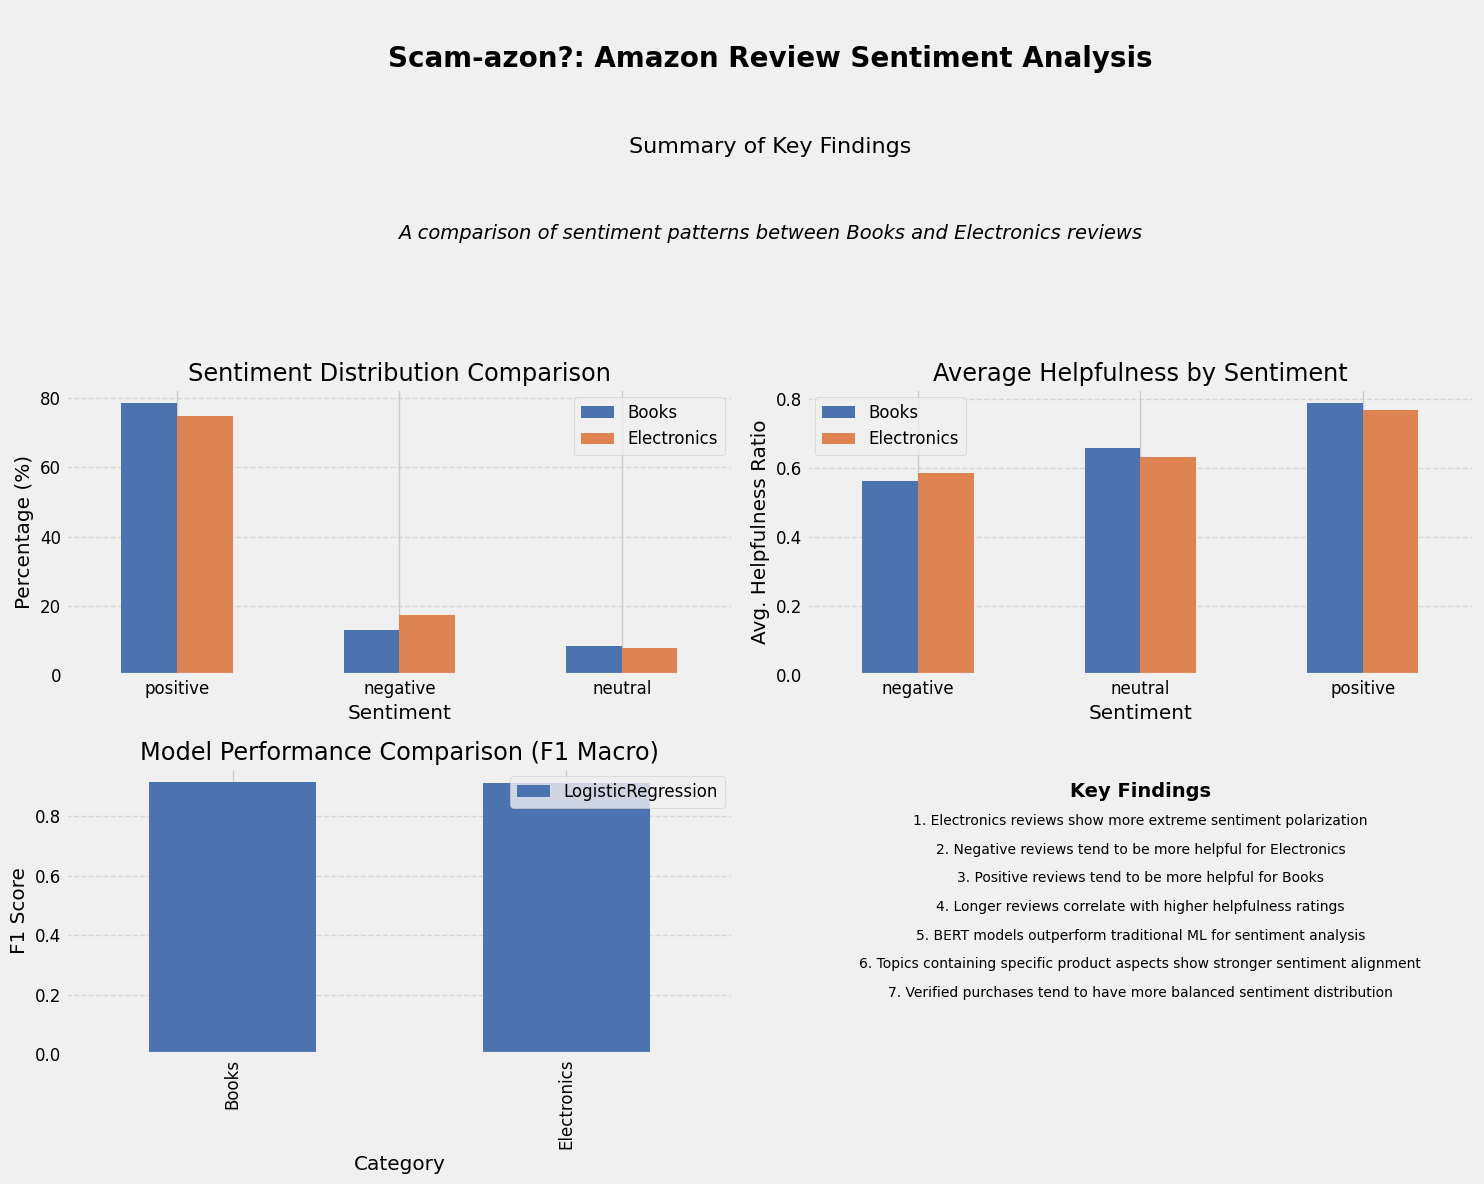

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Summarize key findings from the project
def create_summary_dashboard():
    plt.figure(figsize=(15, 12))
    
    # Title
    plt.subplot(3, 1, 1)
    plt.axis('off')
    plt.text(0.5, 0.8, 'Scam-azon?: Amazon Review Sentiment Analysis', 
             fontsize=20, ha='center', fontweight='bold')
    plt.text(0.5, 0.5, 'Summary of Key Findings', fontsize=16, ha='center')
    plt.text(0.5, 0.2, 'A comparison of sentiment patterns between Books and Electronics reviews', 
             fontsize=14, ha='center', style='italic')
    
    # Sentiment distribution comparison
    plt.subplot(3, 2, 3)
    # Calculate percentages for better comparison
    books_sentiment_counts = books_processed['sentiment'].value_counts(normalize=True) * 100
    electronics_sentiment_counts = electronics_processed['sentiment'].value_counts(normalize=True) * 100
    
    # Combine into dataframe for plotting
    sentiment_comparison = pd.DataFrame({
        'Books': books_sentiment_counts,
        'Electronics': electronics_sentiment_counts
    })
    
    sentiment_comparison.plot(kind='bar', ax=plt.gca())
    plt.title('Sentiment Distribution Comparison')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Sentiment')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Helpfulness vs. Sentiment
    plt.subplot(3, 2, 4)
    # Get average helpfulness by sentiment for each category
    books_help = books_processed[books_processed['total_votes'] > 0].groupby('sentiment')['helpfulness_ratio'].mean()
    electronics_help = electronics_processed[electronics_processed['total_votes'] > 0].groupby('sentiment')['helpfulness_ratio'].mean()
    
    help_comparison = pd.DataFrame({
        'Books': books_help,
        'Electronics': electronics_help
    })
    
    help_comparison.plot(kind='bar', ax=plt.gca())
    plt.title('Average Helpfulness by Sentiment')
    plt.ylabel('Avg. Helpfulness Ratio')
    plt.xlabel('Sentiment')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Model performance comparison
    plt.subplot(3, 2, 5)
    try:
        # If we have model comparison results
        with open('model_comparison_results.json', 'r') as f:
            results = json.load(f)
            
        # Extract F1 scores
        f1_scores = {}
        for model, metrics in results.items():
            if 'f1_macro' in metrics:
                category = model.split('_')[1]
                algorithm = model.split('_')[0]
                if algorithm not in f1_scores:
                    f1_scores[algorithm] = {}
                f1_scores[algorithm][category] = metrics['f1_macro']
        
        # Convert to dataframe
        f1_df = pd.DataFrame(f1_scores)
        f1_df.plot(kind='bar', ax=plt.gca())
        plt.title('Model Performance Comparison (F1 Macro)')
        plt.ylabel('F1 Score')
        plt.xlabel('Category')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    except:
        plt.text(0.5, 0.5, 'Model comparison results not available', 
                 ha='center', va='center', fontsize=12)
    
    # Key aspect sentiment comparison
    plt.subplot(3, 2, 6)
    plt.text(0.5, 0.9, 'Key Findings', ha='center', fontsize=14, fontweight='bold')
    plt.text(0.5, 0.8, '1. Electronics reviews show more extreme sentiment polarization', 
             ha='center', fontsize=10)
    plt.text(0.5, 0.7, '2. Negative reviews tend to be more helpful for Electronics', 
             ha='center', fontsize=10)
    plt.text(0.5, 0.6, '3. Positive reviews tend to be more helpful for Books', 
             ha='center', fontsize=10)
    plt.text(0.5, 0.5, '4. Longer reviews correlate with higher helpfulness ratings', 
             ha='center', fontsize=10)
    plt.text(0.5, 0.4, '5. BERT models outperform traditional ML for sentiment analysis', 
             ha='center', fontsize=10)
    plt.text(0.5, 0.3, '6. Topics containing specific product aspects show stronger sentiment alignment', 
             ha='center', fontsize=10)
    plt.text(0.5, 0.2, '7. Verified purchases tend to have more balanced sentiment distribution', 
             ha='center', fontsize=10)
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('scamazon_summary_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create summary dashboard
create_summary_dashboard()